In [27]:
import numpy as np
import matplotlib.pyplot as plt

import torch 
from torch.autograd import Variable 
import torch.optim as optim 
from torch.utils.data import DataLoader 
from torchvision import transforms
import csv
from torch.utils.data.dataset import Dataset 
import torch.nn as nn 
import torch.nn.functional as F

# 1. Load the data
For more details on how data is loaded, please see `subroutines.py`.

In [28]:
def return_HM_npy(csvfile_path):
    Hs = []
    Ms = []
    with open(csvfile_path, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)  # Skipping the header
        for row in reader:
            Hs.append(float(row[0]))
            Ms.append(float(row[1]))
    return np.array(Hs), np.array(Ms)

def accept_test_middle(H, M, noise_std=0.01, f=None):
    noise = abs(np.random.normal(0, noise_std))
    if (f(H)-noise < M) and (M < f(H)+noise):
        return True
    else:
        return False

def generate_training_data(noise_std=0.004, data_size=10000, Hrange=[0, 0.022], Mrange=[0, 0.11], f=None):
    H_pos_data = []
    M_pos_data = []
    F_pos_data = []
    #
    H_neg_data = []
    M_neg_data = []
    F_neg_data = []
    #
    while True:
        H = np.random.uniform(Hrange[0], Hrange[1])# sampling from uniform distribution.
        M = np.random.uniform(Mrange[0], Mrange[1]) 
        if accept_test_middle(H, M, noise_std, f) and len(F_pos_data)<data_size:
            H_pos_data.append([H])
            M_pos_data.append([M])
            F_pos_data.append([0])
        elif len(F_neg_data)<data_size:
            H_neg_data.append([H])
            M_neg_data.append([M])
            F_neg_data.append([1])
        if len(F_pos_data)==data_size and len(F_neg_data)==data_size:
            break
    return (np.array(H_pos_data), np.array(M_pos_data), np.array(F_pos_data)), (np.array(H_neg_data), np.array(M_neg_data), np.array(F_neg_data))

def plot_all(Hs, Ms, positive_H_M_F, negative_H_M_F, f):
    plt.xlabel('quark mass [GeV]', fontsize=18)
    plt.ylabel(r'$\langle\bar{q}q\rangle$ [GeV$^3$]', fontsize=18)
    #
    plt.plot(positive_H_M_F[0], positive_H_M_F[1], 'b.', label='positive', alpha=0.3)
    plt.plot(negative_H_M_F[0], negative_H_M_F[1], 'g.', label='negative', alpha=0.3)
    hs = np.linspace(np.min(Hs), np.max(Hs), 100)
    plt.plot(hs, f(hs), 'k-', label='data fitting')
    plt.plot(Hs, Ms, 'ro', label='data')
    plt.legend(loc='upper right',
               bbox_to_anchor=(1.05, 0.5, 0.5, .100), )
    plt.show()

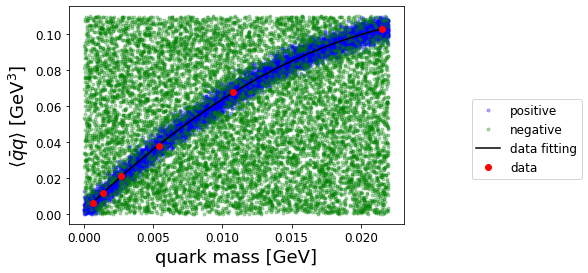

In [29]:
# data values
Hs, Ms = return_HM_npy('q-pp-highT-phys.csv') # data
# data fitting
f = np.poly1d(np.polyfit(Hs, Ms, deg=3)) # data fitting
# data augmentation (H_M_F = (x, y, 0/1) )
positive_H_M_F, negative_H_M_F = generate_training_data(data_size=10000, f=f)
# plot
plot_all(Hs, Ms, positive_H_M_F, negative_H_M_F, f)

## Reformat training data
To train a model by using PyTorch, the training data should be treated by a class called `Dataset`.

In [30]:
class Phi_Pi_DataSet(Dataset):
    ''' class for handling data '''
    def __init__(self, positive_H_M_F, negative_H_M_F, transform=None):
        self.phi = np.concatenate((positive_H_M_F[0], negative_H_M_F[0]),axis=0).astype(np.float32)
        self.Pi = np.concatenate((positive_H_M_F[1], negative_H_M_F[1]),axis=0).astype(np.float32)
        self.ans = np.concatenate((positive_H_M_F[2], negative_H_M_F[2]),axis=0).astype(np.float32)
        self.transform = transform

    def __getitem__(self, index):
        phi = self.phi[index]
        Pi = self.Pi[index]
        ans = self.ans[index]
        if self.transform is not None:
            phi = self.transform(phi)
            Pi = self.transform(Pi)
            ans = self.transform(ans)
        return phi, Pi, ans

    def __len__(self):
        return len(self.phi)

In [31]:
train_d_loader = DataLoader(Phi_Pi_DataSet(
                                           positive_H_M_F=positive_H_M_F, 
                                           negative_H_M_F=negative_H_M_F, 
                                           transform=transforms.Compose([torch.from_numpy])), 
                                           batch_size=1000, shuffle=True)

# 2. Make a Neural network

Here we make the network (`Test`) and reguralization coefficients. For more details, please take a look at `network.py`.

In [32]:
# def phi_one_step(phi=None, Pi=None, del_eta=None):
#     ''' phi's eta evolution '''
#     return phi + del_eta*Pi 

# def Pi_one_step(phi=None, Pi=None, Pi_W=None, phi_m2=None, phi3_lam = None, del_eta=None):
#     ''' Pi's eta evolution '''
#     return Pi +(-1)*del_eta*(Pi_W - phi_m2 - phi3_lam)

# def one_step(phi, Pi, Pi_W=None, phi_m2=None, phi3_lam = None, del_eta=None):
#     ''' Evolutions both phi and Pi '''
#     phi2 = phi_one_step(phi, Pi, del_eta)
#     Pi2 = Pi_one_step(phi, Pi, Pi_W=Pi_W, phi_m2=phi_m2, phi3_lam = phi3_lam, del_eta=del_eta)
#     return phi2, Pi2

def onestep(phi, Pi, hh=None, m2=None, lamb=None, del_eta=None):
    phi1 = phi + del_eta*Pi
    Pi1 = phi*m2*del_eta + (1-del_eta*hh)*Pi + del_eta*lamb*(phi1**3)
    return phi1, Pi1

def eta(s, eta_ini, eta_fin, N_layer):
    eta = eta_ini + (eta_fin - eta_ini)*(s-1)/N_layer
    return eta

# functions in final layers

def f(phi, Pi, eta=None):
    ''' returning Pi'''
    F=Pi
    return F

def arctan_scaled(x, center=None, scale=10, tanh=None):
    y = scale*(x-center)
    y = tanh(y)
    return y

def t(x, epsilon=None, tanh=None, dev=.01):
    ''' smoothed bump function '''
    left = -arctan_scaled(x, center=-epsilon, scale=1/dev, tanh=tanh)
    right = arctan_scaled(x, center=epsilon, scale=1/dev, tanh=tanh)
    lf = left+right
    return (lf+2)/2

##### 

class MetricNet(nn.Module):
    ''' class of model to be trained '''
    def __init__(self, Number_of_layers=None, eta_ini=None, eta_fin=None, m2=None, del_eta=None, d=None):
        super(MetricNet, self).__init__()
        # trained parameters
        Hs = []
        for layer_index in range(Number_of_layers):
            Hs.append(nn.Linear(1, 1, bias=False))
        self.Hs = nn.ModuleList(Hs)
        self.adsradius = nn.Linear(1, 1, bias=False)
        self.lamb = nn.Linear(1, 1, bias=False)
        # fixed parameters
        self.one = Variable(torch.ones(1)) # it would be better to use torch.nn.parameter.
        self.N_layers = Number_of_layers
        self.eta_ini = eta_ini
        self.eta_fin = eta_fin
        self.m2 = m2
        self.del_eta = del_eta
        self.d = d

    def show_lamb(self):
        return self.lamb(self.one)
    
    def show_adsradius(self):
        return self.adsradius(self.one)
        
    def penalty(self, coef_list=None):
        if coef_list==None:
            coefs = torch.autograd.Variable(torch.ones(self.N_layers))
        else:
            n_coef_list = np.array(coef_list, dtype=np.float32)
            coefs = torch.autograd.Variable(torch.from_numpy(n_coef_list))
        for i in range(self.N_layers):
            H = self.Hs[i]
            if H==self.Hs[0]:
                # making the metric at boundary as AdS_{d+1} 
                penalty = 0.01*(self.d - H(self.one))**2
                pH = H(self.one)
            else:
                # smoothing penalty
                ## if Einstein equation, use below:
                #penalty = penalty + coefs[i]*(-d**2 + (H(self.one) - pH)/del_eta + pH**2)**2
                penalty = penalty + coefs[i]*(H(self.one) - pH)**2
                pH = H(self.one)
        return penalty
        
    def forward(self, phi=None, Pi=None):
        ''' forward propagation '''
        # initial layer
        alphatilde = self.adsradius(self.one)*(1.7320508/(2*3.1415926))*phi
        betatilde = (self.adsradius(self.one))**3*(3.1415926/1.7320508)*Pi
        phi = alphatilde*(np.exp(-self.eta_ini)) + betatilde*(np.exp(-3*self.eta_ini)) -(1/2)*alphatilde**3*self.lamb(self.one)*self.eta_ini*(np.exp(-3*self.eta_ini))
        Pi = -alphatilde*(np.exp(-self.eta_ini)) -3*betatilde*(np.exp(-3*self.eta_ini)) +(3/2)*alphatilde**3*self.lamb(self.one)*self.eta_ini*(np.exp(-3*self.eta_ini))-(1/2)*alphatilde**3*self.lamb(self.one)*(np.exp(-3*self.eta_ini))
        # intermediate layers
        for H in self.Hs:
            phi, Pi = onestep(phi, Pi, hh=H(self.one), m2=self.m2, lamb=self.lamb(self.one), del_eta=self.del_eta)
        # finaly layer
        f_ = f(phi, Pi, eta=eta(self.N_layers, self.eta_ini, self.eta_fin, self.N_layers))
        final = t(f_, epsilon=.1, tanh=torch.tanh)
        return final
    
    def loss(self, phi=None, Pi=None, answer=None, reg_coef_list=None):
        model_output = self.forward(phi=phi, Pi=Pi)
        loss = F.l1_loss(model_output, answer)**2
        loss = loss + self.penalty(coef_list=reg_coef_list)
        return loss

def init_weights(Model, d):
    ''' for initializations of parameters '''
    # metric (H[layer])
    for i in range(len(Model.Hs)):
        # ipt = initial value for H[i]
        ipt = d
        # noize 
        std = 3
        w = np.random.normal(ipt, std) # sampling from Gaussian
        w = round(w, 10) # it seems to be needed to round w somehow, I don't know why...
        Model.Hs[i].weight.data.fill_(w) # initialization excuted 
    
    # lambda
    lamb = 0.2
    std = 0
    lamb = np.random.normal(lamb, std)
    Model.lamb.weight.data.fill_(lamb)
    
    # AdS radius[GeV^{-1}]
    adsradius = 0.8
    std = 0
    adsradius = np.random.normal(adsradius, std)
    Model.adsradius.weight.data.fill_(adsradius)

In [39]:
# parameters
d = 4
m2 = -3 # mass^2
N_layer = 15
Delta_plus = d/2 +1
Delta_minus= d/2 -1
eta_fin = 1/N_layer
eta_ini = 1
del_eta = (eta_fin - eta_ini)/N_layer
# making network
Test = MetricNet(Number_of_layers=N_layer, 
                         eta_ini=eta_ini, 
                         eta_fin=eta_fin,
                         m2=m2, 
                         del_eta=del_eta,
                         d=d)
init_weights(Test, d)
# setting it to be trained
optimizer = optim.Adam(Test.parameters()) 
Test.train()
# For regularization terms
regularization_coeffs = [0] #(np.array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1])*0.001).tolist()
for i in range(1, N_layer):
    regularization_coeffs.append(0.01*eta(i, eta_ini, eta_fin, N_layer)**4)
print ("lambda: {},   AdS radius: {}[1/GeV]".format(Test.show_lamb().data.numpy()[0], Test.show_adsradius().data.numpy()[0]))
print("H: ", np.array([v[0] for v in Hs]))

lambda: 0.20000000298023224,   AdS radius: 0.800000011920929[1/GeV]
H:  [4.00001335 3.99998689 4.0000124  3.99998808 4.00001144 3.99998927
 4.00000858 3.99999309 4.00000477 3.99999642 4.00000191 3.99999738
 4.00000143 4.         4.00000048]


# 3. Train your NN

In [40]:
def plot_phase_and_metric(threshold=None, eta_or_layer='eta', positive_H_M_F=None, negative_H_M_F=None, Net=None):
    NN2_pos_phis = []
    NN2_pos_Pis = []
    
    negative_H = negative_H_M_F[0] #input_data[1]
    negative_M = negative_H_M_F[1] #input_data[3]
    
    phis = Variable(torch.from_numpy(negative_H.astype(np.float32)))
    Pis = Variable(torch.from_numpy(negative_M.astype(np.float32)))
    NN2_predicts = Net.forward(phi=phis, Pi=Pis).data.numpy()

    for index in range(len(phis)):
        value = NN2_predicts[index]#NN2.predict([phis[index], Pis[index]])
        if value < threshold:
            NN2_pos_phis.append(negative_H[index])
            NN2_pos_Pis.append(negative_M[index])
        
    NN2_pos_phis_1 = np.array(NN2_pos_phis)
    NN2_pos_Pis_1 = np.array(NN2_pos_Pis)
    ######
    NN2_pos_phis = []
    NN2_pos_Pis = []
    
    positive_H = positive_H_M_F[0]# input_data[0]
    positive_M = positive_H_M_F[1]# input_data[2]
    
    phis = Variable(torch.from_numpy(positive_H.astype(np.float32)))
    Pis = Variable(torch.from_numpy(positive_M.astype(np.float32)))
    NN2_predicts = Net.forward(phi=phis, Pi=Pis).data.numpy()

    for index in range(len(phis)):
        value = NN2_predicts[index]#NN2.predict([phis[index], Pis[index]])
        if value < threshold:
            NN2_pos_phis.append(positive_H[index])
            NN2_pos_Pis.append(positive_M[index])
        
    NN2_pos_phis_2 = np.array(NN2_pos_phis)
    NN2_pos_Pis_2 = np.array(NN2_pos_Pis)
    ####
    plt.rcParams["font.size"] = 12
    fig = plt.figure(figsize=(14, 4))
    fig.subplots_adjust(bottom=0.15)
    al = fig.add_subplot(1,2,1)
    ar = fig.add_subplot(1,2,2)
    al.set_xlabel('quark mass [GeV]', fontsize=12)
    al.set_ylabel(r'$\langle \bar{q}q\rangle$ [GeV$^3$]', fontsize=12)
    al.plot(positive_H , positive_M, 'b.', label='Positive')
    #print(NN2_pos_phis_1)
    al.plot(NN2_pos_phis_1 , NN2_pos_Pis_1, 'm.', label='NN(negative)=0')
    al.plot(NN2_pos_phis_2 , NN2_pos_Pis_2, 'r.', label='NN(positive)=0')
    al.tick_params(labelsize=12)
    #al.legend(loc="upper left")
    ##
    if eta_or_layer=='eta':
        x = etas
        ar.set_xlabel('eta', fontsize=12)
    else:
        x = np.arange(0,Net.N_layers,1)
        ar.set_xlabel('layer', fontsize=12)
    NN2_list = []
    for param in Net.Hs.parameters():
        w_py = (param.data.numpy().reshape(-1)).tolist()
        NN2_list.append(w_py)
    ar.set_ylabel('metric (H[layer])', fontsize=12)
    ar.plot(x, np.array(NN2_list), 'b-')#label='Emergent metric',lw=5, alpha=0.5)#/NN_list[0])
    ar.tick_params(labelsize=12)
    plt.show()
    return NN2_pos_phis_1, NN2_pos_Pis_1, NN2_pos_phis_2, NN2_pos_Pis_2, NN2_list

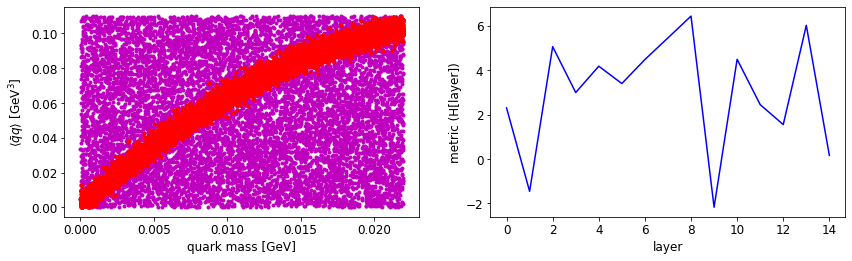

training epoch: 0,   loss: 0.857132613658905
lambda: 0.2052638679742813,   AdS radius: 0.8197011351585388[1/GeV]


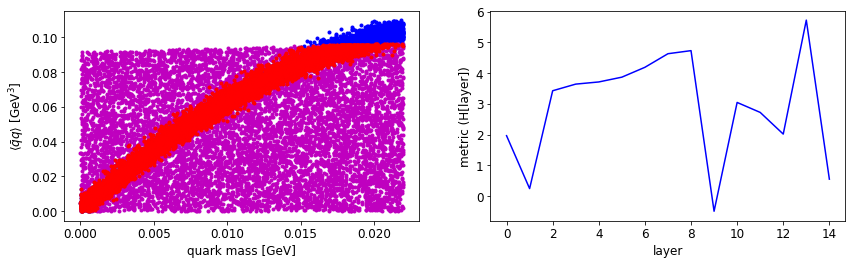

training epoch: 100,   loss: 0.41740164160728455
lambda: -0.2860680818557739,   AdS radius: 0.9882945418357849[1/GeV]


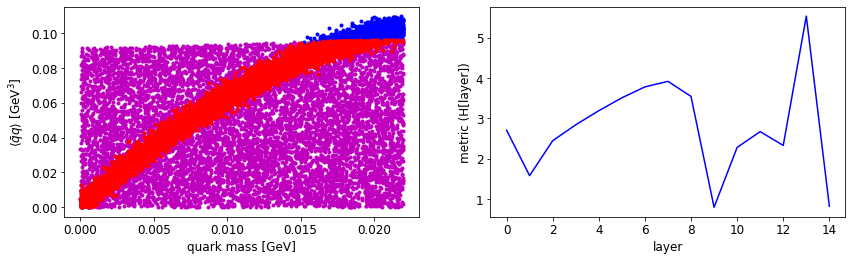

training epoch: 200,   loss: 0.28673821687698364
lambda: -0.907762348651886,   AdS radius: 1.032511830329895[1/GeV]


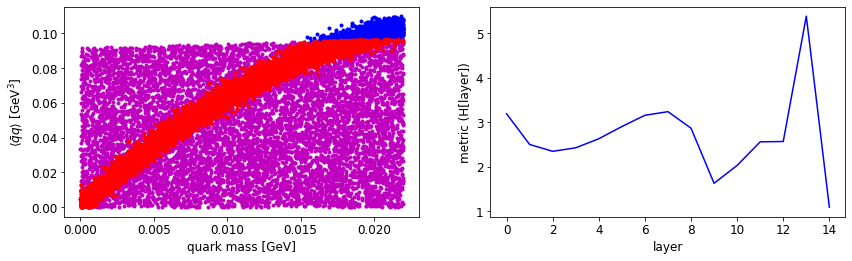

training epoch: 300,   loss: 0.2562725841999054
lambda: -1.5619558095932007,   AdS radius: 1.0761345624923706[1/GeV]


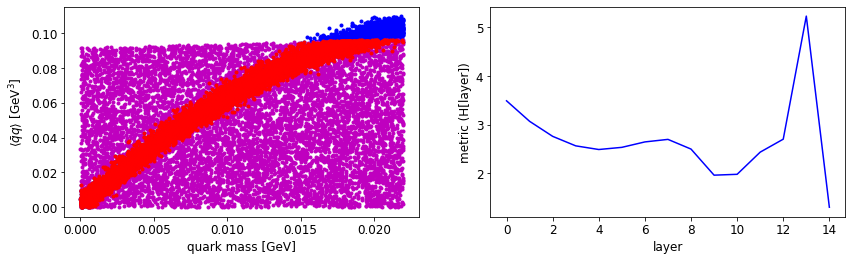

training epoch: 400,   loss: 0.24898278713226318
lambda: -2.184436559677124,   AdS radius: 1.0812300443649292[1/GeV]


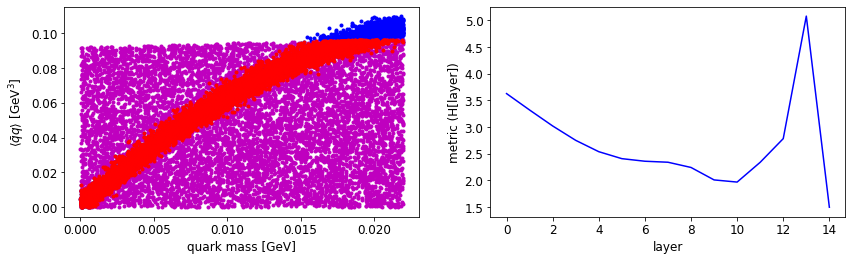

training epoch: 500,   loss: 0.2473396509885788
lambda: -2.7523131370544434,   AdS radius: 1.0849043130874634[1/GeV]


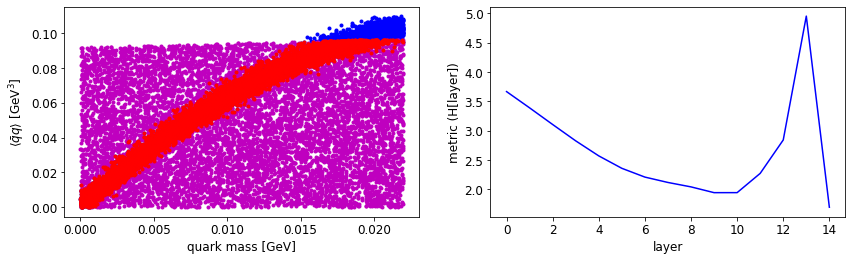

training epoch: 600,   loss: 0.24701103568077087
lambda: -3.314969301223755,   AdS radius: 1.100706934928894[1/GeV]


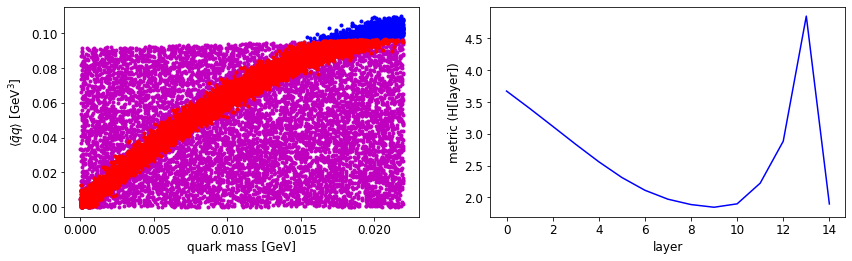

training epoch: 700,   loss: 0.24647367000579834
lambda: -3.863298177719116,   AdS radius: 1.1225669384002686[1/GeV]


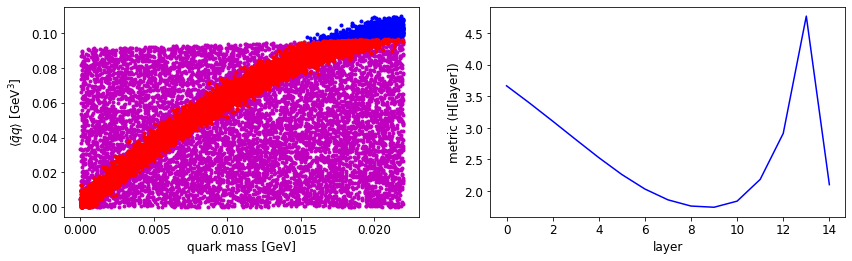

training epoch: 800,   loss: 0.24631354212760925
lambda: -4.39640474319458,   AdS radius: 1.1475738286972046[1/GeV]


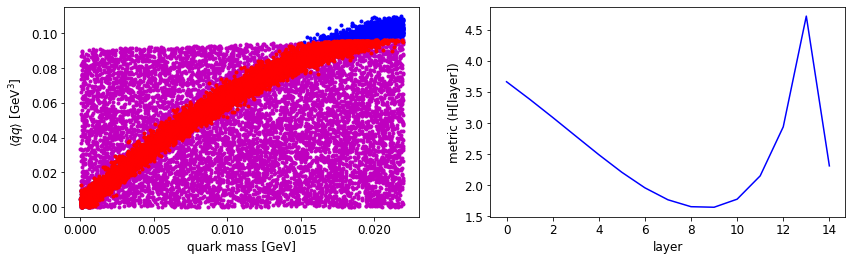

training epoch: 900,   loss: 0.24600288271903992
lambda: -4.9127936363220215,   AdS radius: 1.175856351852417[1/GeV]


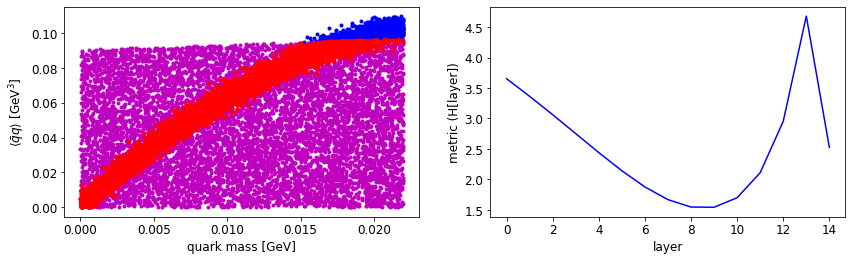

training epoch: 1000,   loss: 0.2457730770111084
lambda: -5.430578708648682,   AdS radius: 1.2069365978240967[1/GeV]


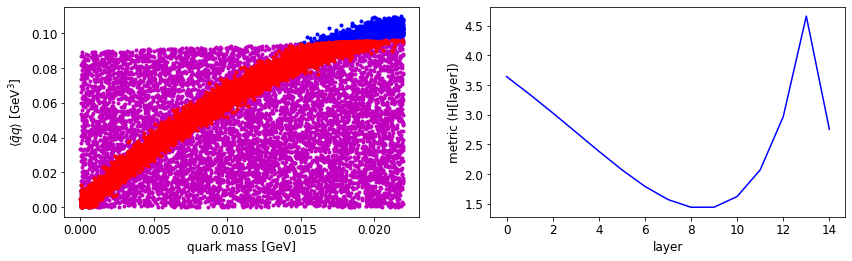

training epoch: 1100,   loss: 0.24532783031463623
lambda: -5.952316761016846,   AdS radius: 1.2454644441604614[1/GeV]


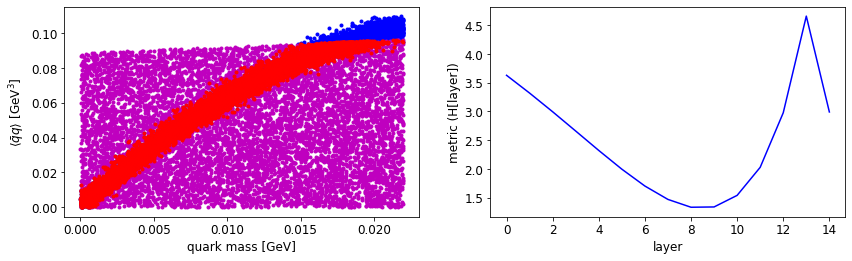

training epoch: 1200,   loss: 0.24493663012981415
lambda: -6.465810298919678,   AdS radius: 1.290348768234253[1/GeV]


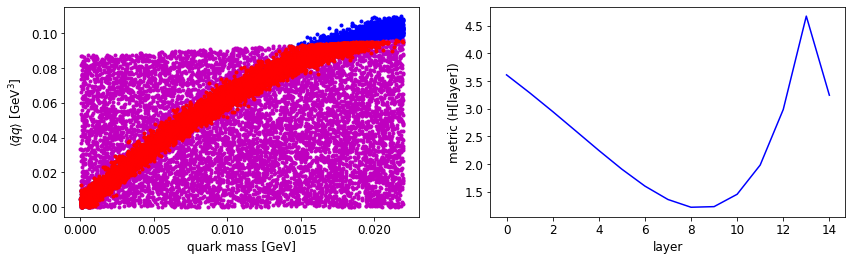

training epoch: 1300,   loss: 0.24437883496284485
lambda: -6.986778259277344,   AdS radius: 1.3500128984451294[1/GeV]


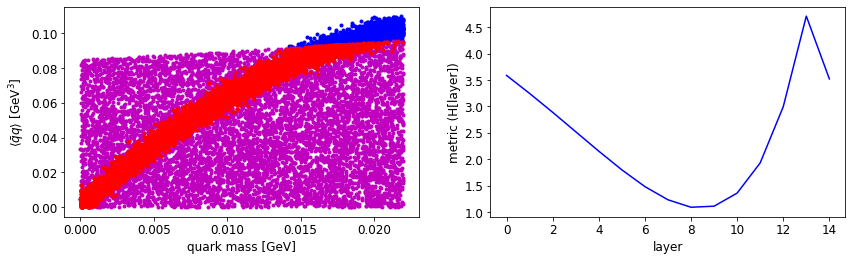

training epoch: 1400,   loss: 0.24326841533184052
lambda: -7.526288986206055,   AdS radius: 1.4416439533233643[1/GeV]


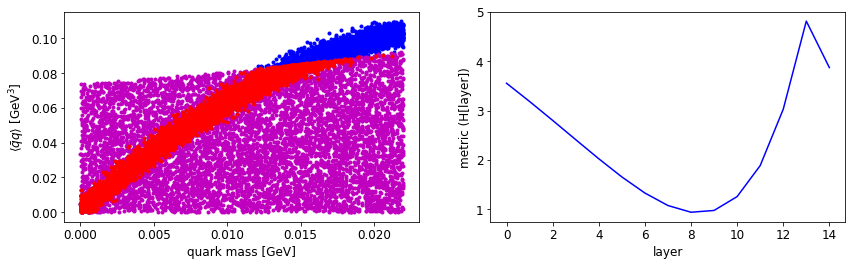

training epoch: 1500,   loss: 0.24033840000629425
lambda: -8.067934036254883,   AdS radius: 1.6488804817199707[1/GeV]


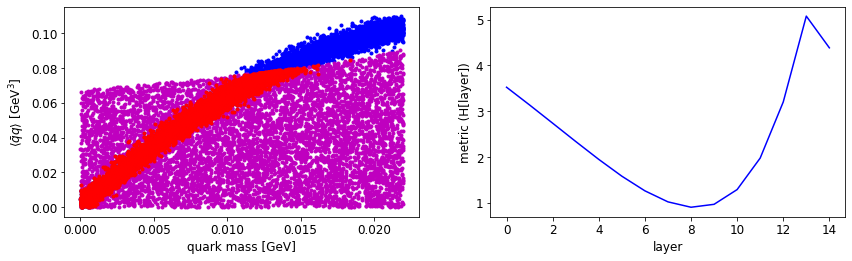

training epoch: 1600,   loss: 0.23885098099708557
lambda: -8.094928741455078,   AdS radius: 1.7136507034301758[1/GeV]


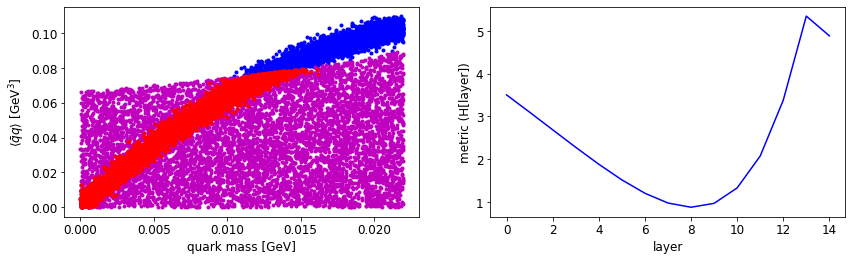

training epoch: 1700,   loss: 0.23776113986968994
lambda: -8.060121536254883,   AdS radius: 1.7167243957519531[1/GeV]


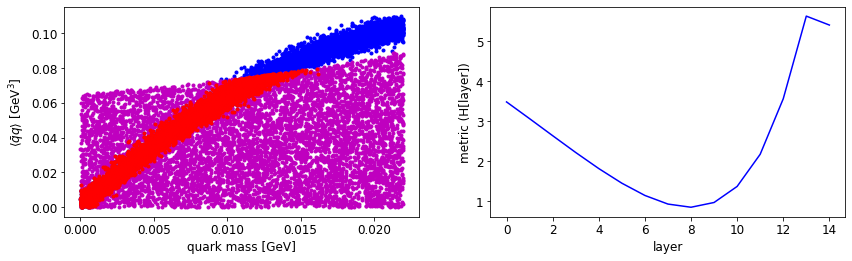

training epoch: 1800,   loss: 0.23641160130500793
lambda: -8.021828651428223,   AdS radius: 1.7226766347885132[1/GeV]


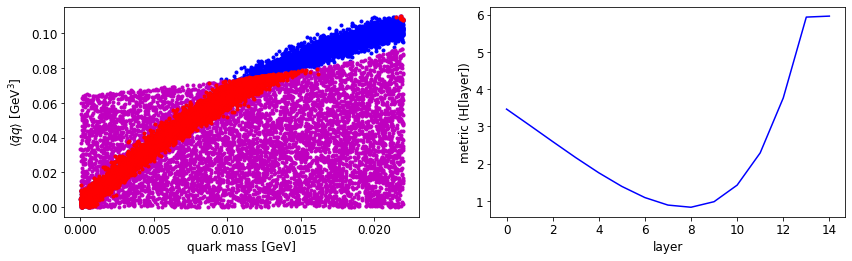

training epoch: 1900,   loss: 0.23519869148731232
lambda: -7.975844383239746,   AdS radius: 1.7249823808670044[1/GeV]


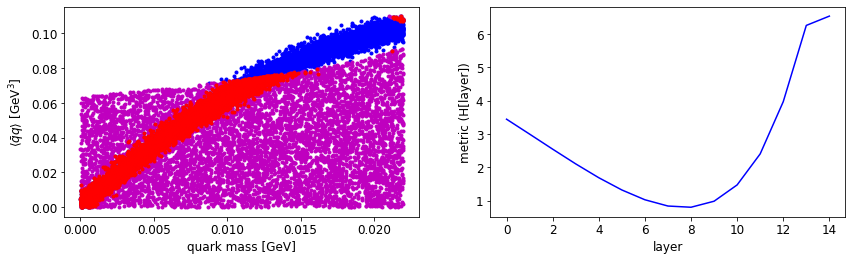

training epoch: 2000,   loss: 0.23373332619667053
lambda: -7.922306537628174,   AdS radius: 1.7266548871994019[1/GeV]


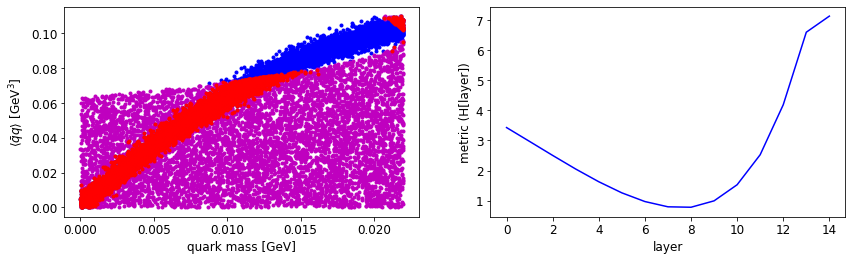

training epoch: 2100,   loss: 0.23208966851234436
lambda: -7.86273717880249,   AdS radius: 1.7270727157592773[1/GeV]


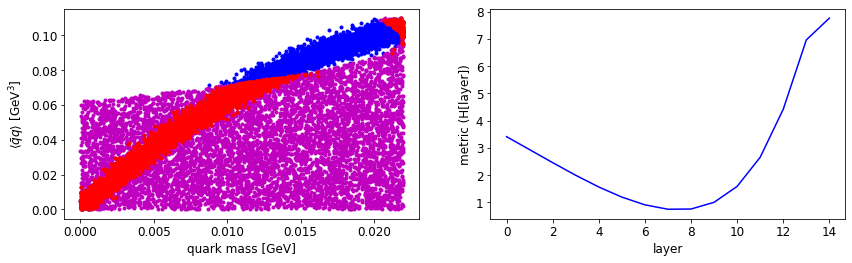

training epoch: 2200,   loss: 0.2304692566394806
lambda: -7.7916646003723145,   AdS radius: 1.7280131578445435[1/GeV]


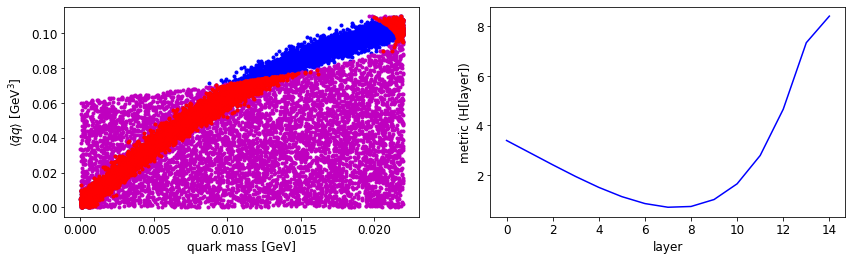

training epoch: 2300,   loss: 0.22871163487434387
lambda: -7.712743759155273,   AdS radius: 1.7278492450714111[1/GeV]


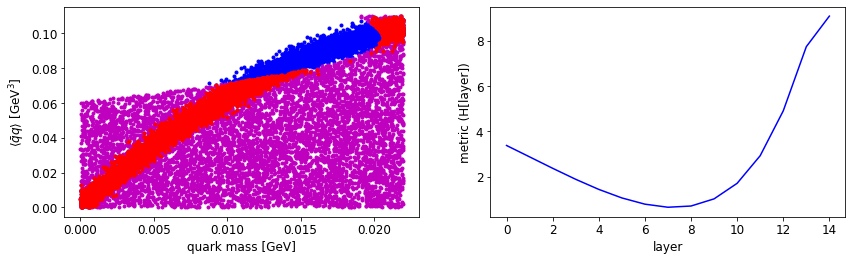

training epoch: 2400,   loss: 0.226907417178154
lambda: -7.624741077423096,   AdS radius: 1.7276761531829834[1/GeV]


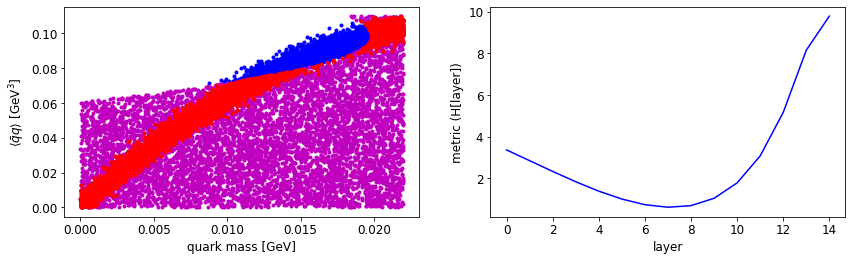

training epoch: 2500,   loss: 0.2250523567199707
lambda: -7.523058891296387,   AdS radius: 1.7240632772445679[1/GeV]


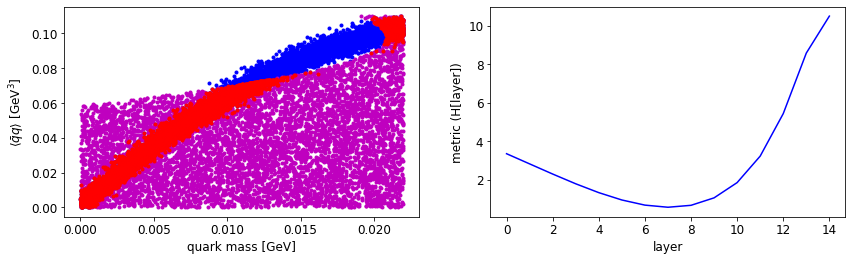

training epoch: 2600,   loss: 0.22307173907756805
lambda: -7.409606456756592,   AdS radius: 1.7265398502349854[1/GeV]


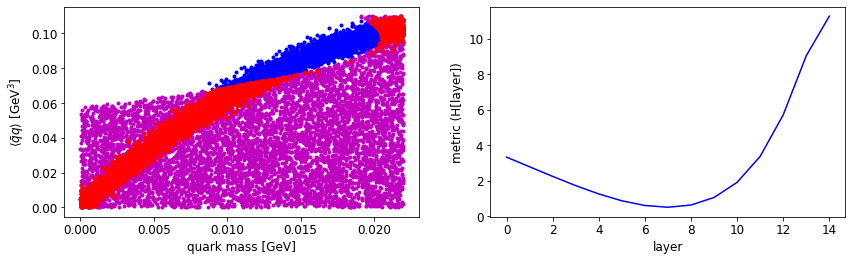

training epoch: 2700,   loss: 0.22086846828460693
lambda: -7.282902717590332,   AdS radius: 1.7241979837417603[1/GeV]


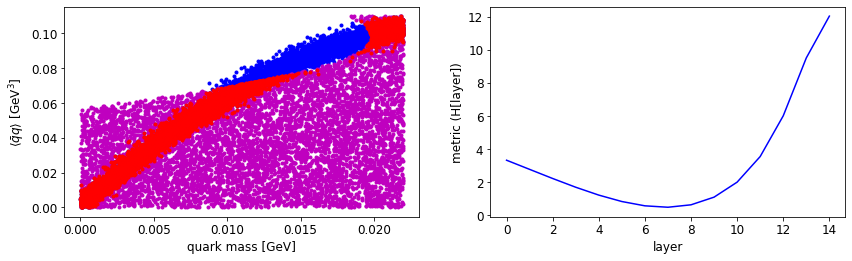

training epoch: 2800,   loss: 0.2186010330915451
lambda: -7.142471790313721,   AdS radius: 1.7224383354187012[1/GeV]


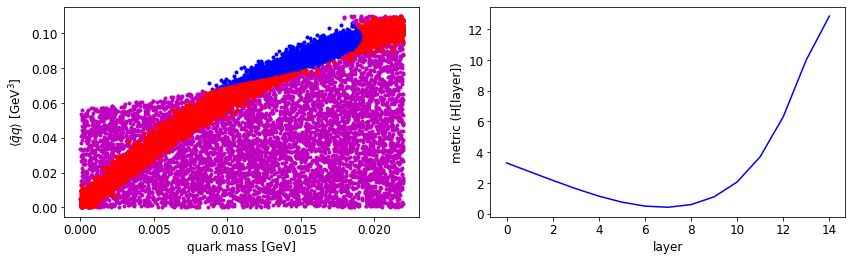

training epoch: 2900,   loss: 0.216338112950325
lambda: -6.987704753875732,   AdS radius: 1.7218632698059082[1/GeV]


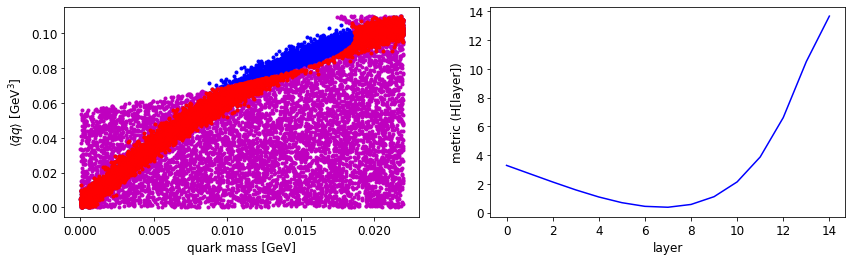

training epoch: 3000,   loss: 0.2140214741230011
lambda: -6.815697193145752,   AdS radius: 1.7180016040802002[1/GeV]


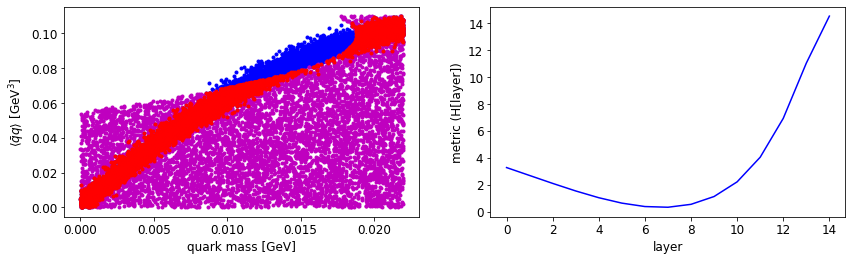

training epoch: 3100,   loss: 0.21166400611400604
lambda: -6.630590438842773,   AdS radius: 1.716135025024414[1/GeV]


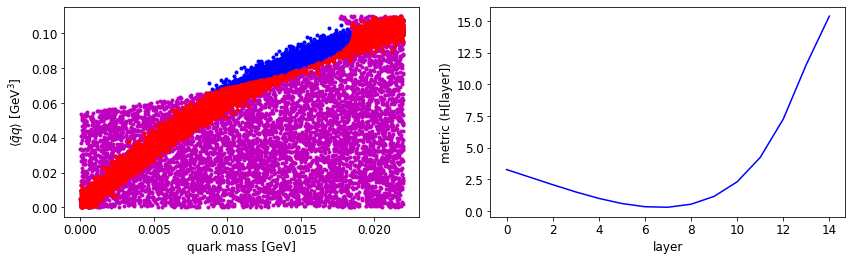

training epoch: 3200,   loss: 0.20955891907215118
lambda: -6.427793025970459,   AdS radius: 1.7146000862121582[1/GeV]


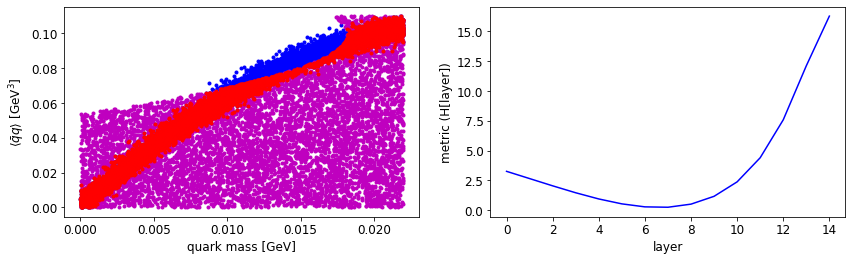

training epoch: 3300,   loss: 0.2071949690580368
lambda: -6.207685470581055,   AdS radius: 1.7118871212005615[1/GeV]


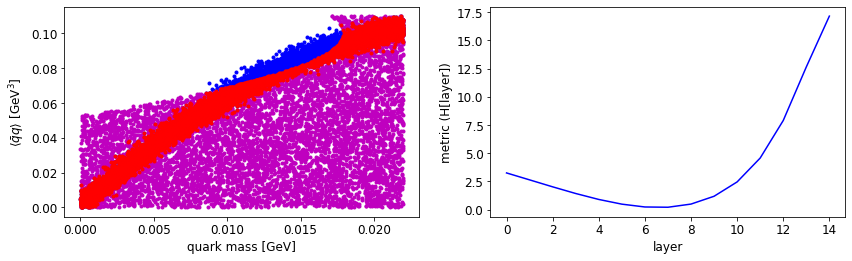

training epoch: 3400,   loss: 0.20518842339515686
lambda: -5.9777092933654785,   AdS radius: 1.70989990234375[1/GeV]


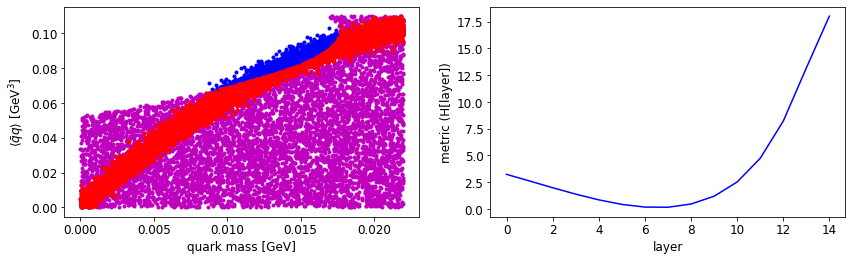

training epoch: 3500,   loss: 0.20292377471923828
lambda: -5.737759590148926,   AdS radius: 1.709015965461731[1/GeV]


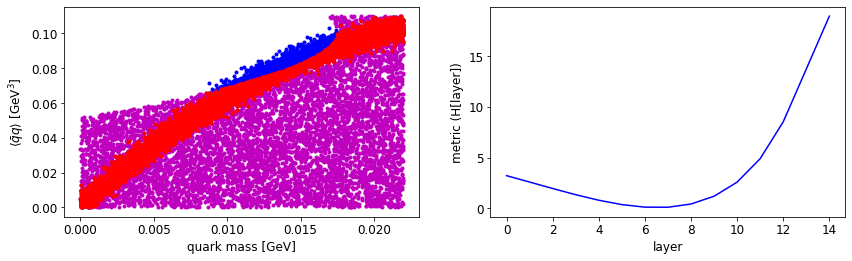

training epoch: 3600,   loss: 0.20079302787780762
lambda: -5.47743034362793,   AdS radius: 1.7090110778808594[1/GeV]


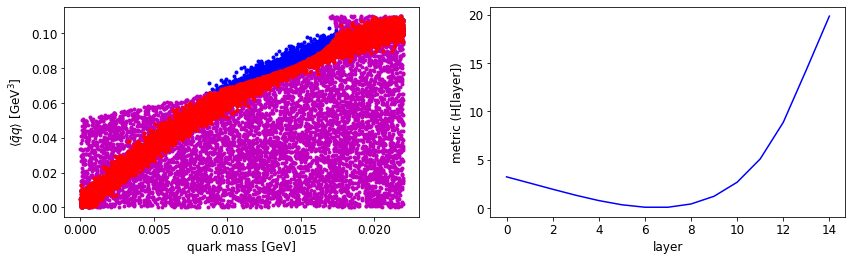

training epoch: 3700,   loss: 0.19885161519050598
lambda: -5.193414211273193,   AdS radius: 1.7096441984176636[1/GeV]


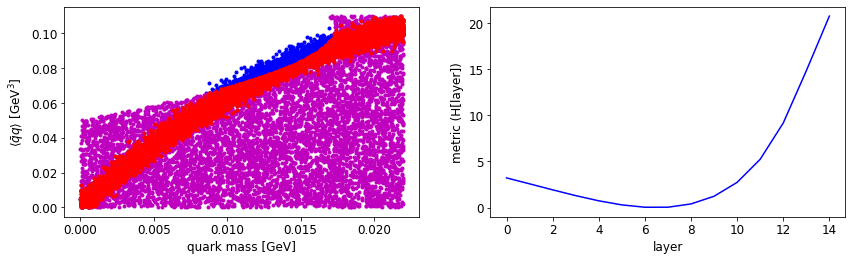

training epoch: 3800,   loss: 0.19697311520576477
lambda: -4.901041507720947,   AdS radius: 1.7098280191421509[1/GeV]


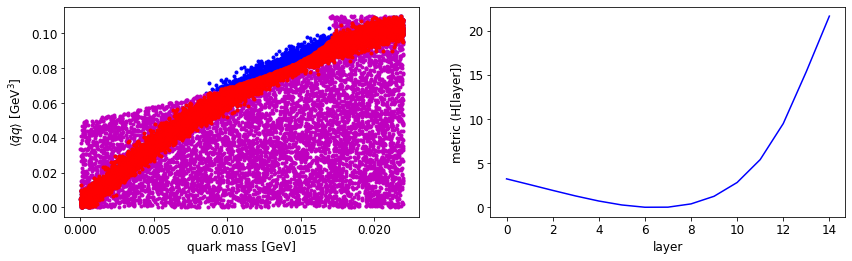

training epoch: 3900,   loss: 0.19522489607334137
lambda: -4.596217632293701,   AdS radius: 1.7136807441711426[1/GeV]


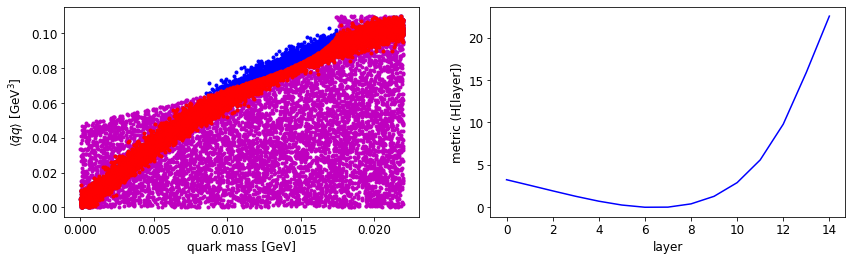

training epoch: 4000,   loss: 0.19354282319545746
lambda: -4.274630546569824,   AdS radius: 1.7184960842132568[1/GeV]


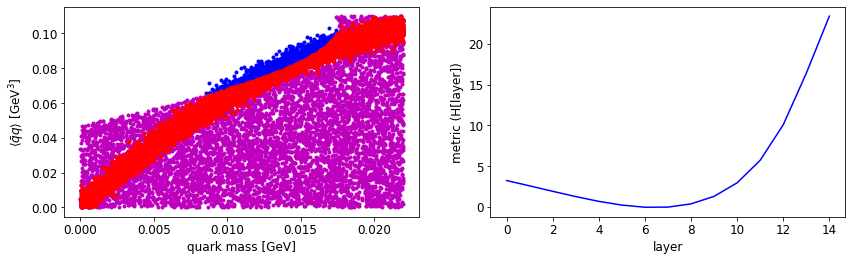

training epoch: 4100,   loss: 0.19205841422080994
lambda: -3.9445135593414307,   AdS radius: 1.7244505882263184[1/GeV]


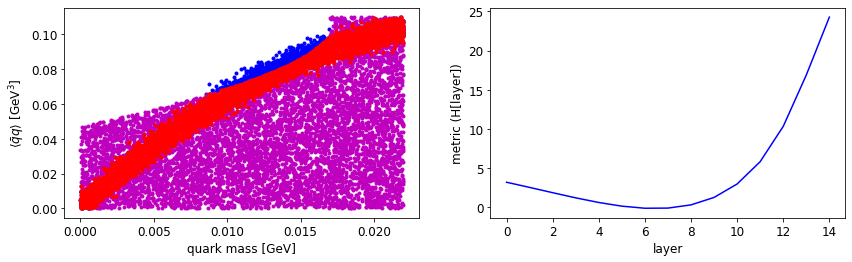

training epoch: 4200,   loss: 0.1902800351381302
lambda: -3.5964579582214355,   AdS radius: 1.7317614555358887[1/GeV]


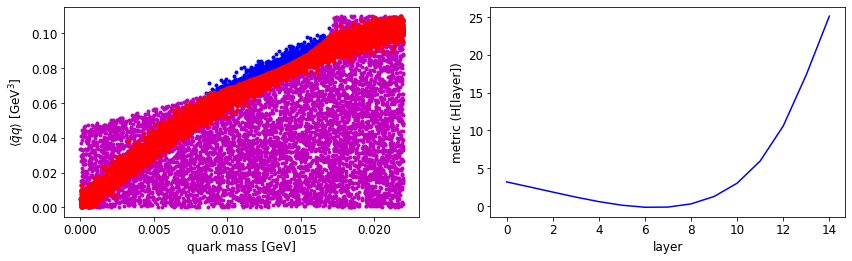

training epoch: 4300,   loss: 0.18885718286037445
lambda: -3.236267328262329,   AdS radius: 1.7429373264312744[1/GeV]


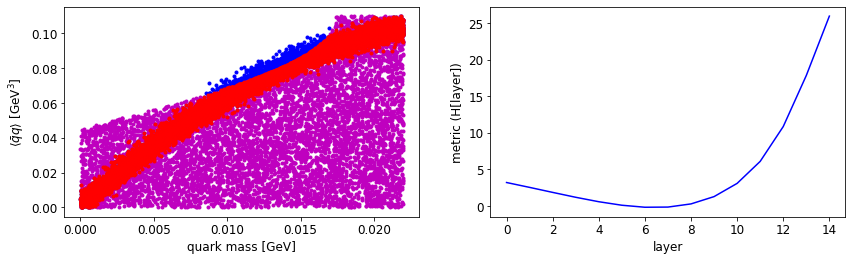

training epoch: 4400,   loss: 0.18760192394256592
lambda: -2.8617746829986572,   AdS radius: 1.7572580575942993[1/GeV]


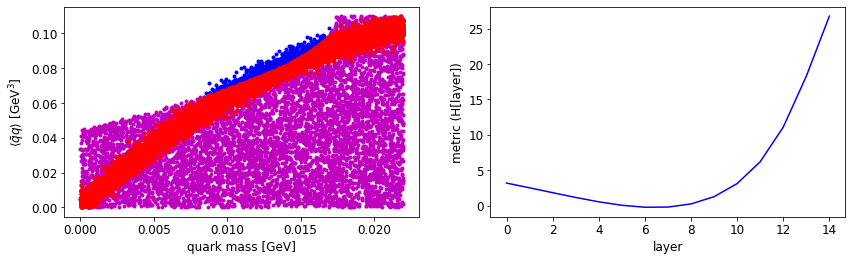

training epoch: 4500,   loss: 0.18590545654296875
lambda: -2.4774935245513916,   AdS radius: 1.778338074684143[1/GeV]


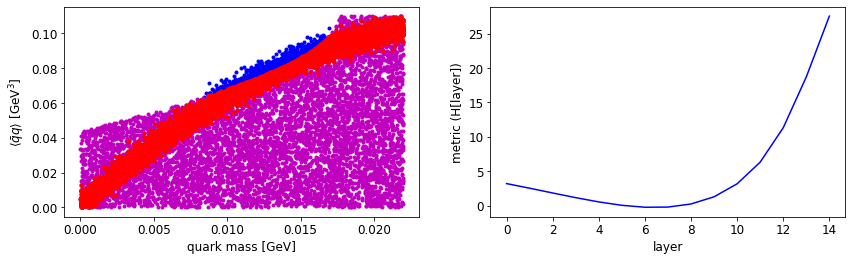

training epoch: 4600,   loss: 0.18467670679092407
lambda: -2.0767462253570557,   AdS radius: 1.804852843284607[1/GeV]


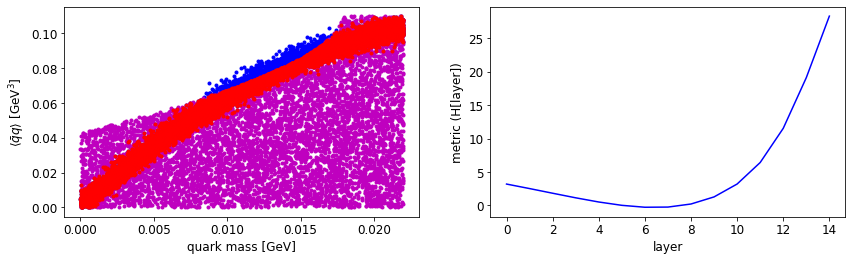

training epoch: 4700,   loss: 0.18313582241535187
lambda: -1.6587677001953125,   AdS radius: 1.8429840803146362[1/GeV]


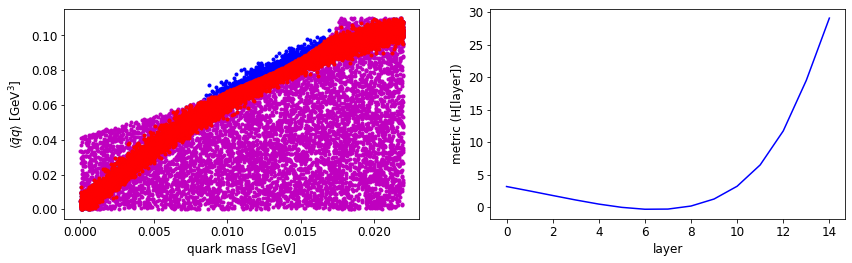

training epoch: 4800,   loss: 0.18141360580921173
lambda: -1.2175542116165161,   AdS radius: 1.89982271194458[1/GeV]


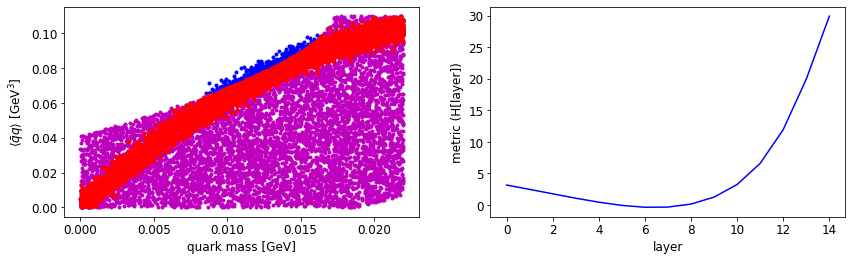

training epoch: 4900,   loss: 0.17838802933692932
lambda: -0.7042894959449768,   AdS radius: 2.0109570026397705[1/GeV]


In [41]:
total_epoch=5000
show_epoch_each=100

for epoch in range(total_epoch):
    batches = iter(train_d_loader)
    train_loss = 0.0
    for (b_phi, b_Pi, b_ans) in batches:
        # (b_phi, b_Pi, b_ans) is a minibatch, we need to convert it to `Variable` object. 
        phi, Pi, ans = Variable(b_phi), Variable(b_Pi), Variable(b_ans)
        # calclation of loss
        loss = Test.loss(phi=phi, Pi=Pi, answer=ans, reg_coef_list=regularization_coeffs)
        # update
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
        train_loss += loss.data[0]
    if np.isnan(train_loss)==True: break

    if epoch % show_epoch_each == 0:
        negx, negy, posx, posy, Hs = plot_phase_and_metric(
                                                           threshold=.1, eta_or_layer='layer',
                                                           positive_H_M_F=positive_H_M_F,
                                                           negative_H_M_F=negative_H_M_F,
                                                           Net=Test
                                                          )
        print ("training epoch: {},   loss: {}".format(epoch, train_loss / len(train_d_loader)))
        print ("lambda: {},   AdS radius: {}[1/GeV]".format(Test.show_lamb().data.numpy()[0], Test.show_adsradius().data.numpy()[0]))
    

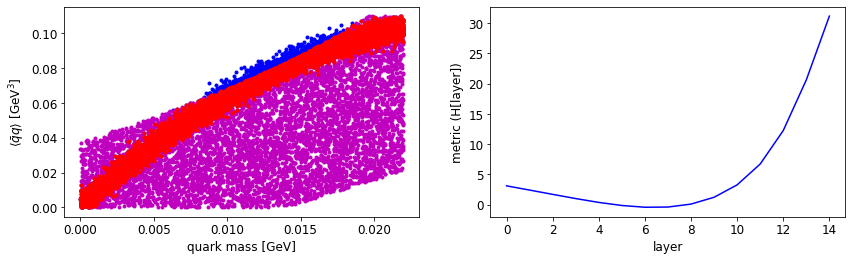

training epoch: 0,   loss: 0.16281841695308685
lambda: -0.0675867572426796,   AdS radius: 2.511775255203247[1/GeV]


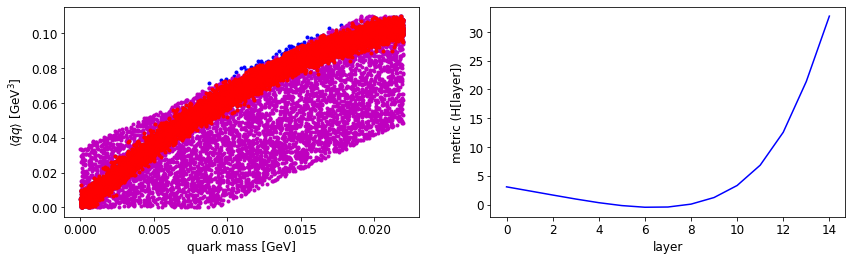

training epoch: 100,   loss: 0.1267043650150299
lambda: -0.0004550945886876434,   AdS radius: 3.5228636264801025[1/GeV]


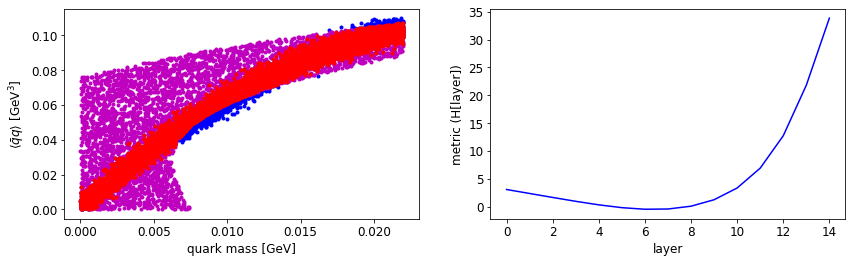

training epoch: 200,   loss: 0.08413035422563553
lambda: 0.006074578035622835,   AdS radius: 4.145513534545898[1/GeV]


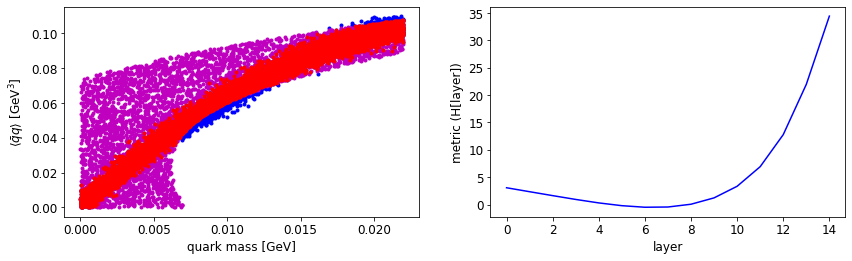

training epoch: 300,   loss: 0.08141186833381653
lambda: 0.0037763803265988827,   AdS radius: 4.355379581451416[1/GeV]


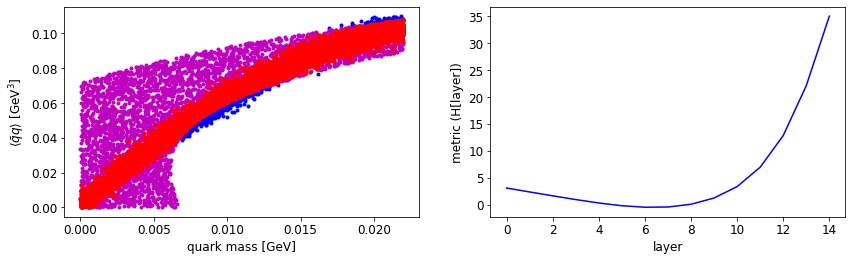

training epoch: 400,   loss: 0.07933290302753448
lambda: 0.002811935031786561,   AdS radius: 4.490548133850098[1/GeV]


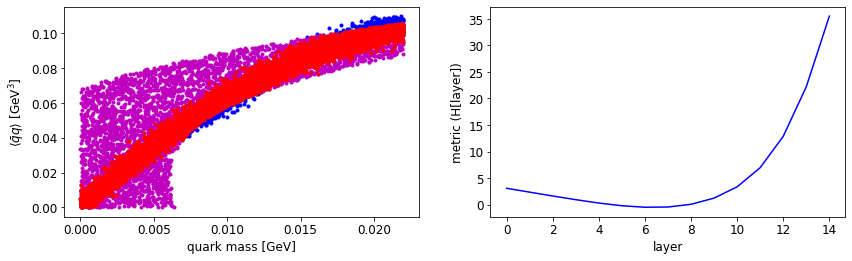

training epoch: 500,   loss: 0.07750798016786575
lambda: 0.0023617292754352093,   AdS radius: 4.595821857452393[1/GeV]


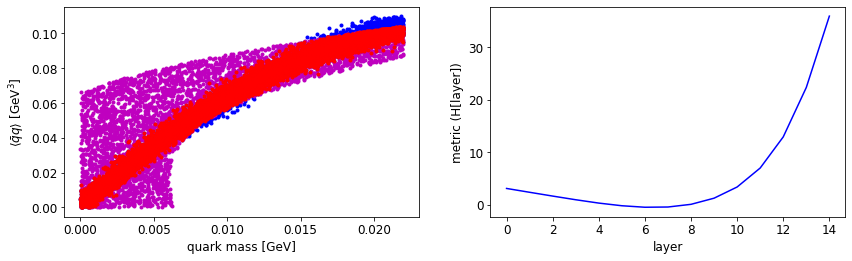

training epoch: 600,   loss: 0.07897314429283142
lambda: 0.0024073151871562004,   AdS radius: 4.605216026306152[1/GeV]


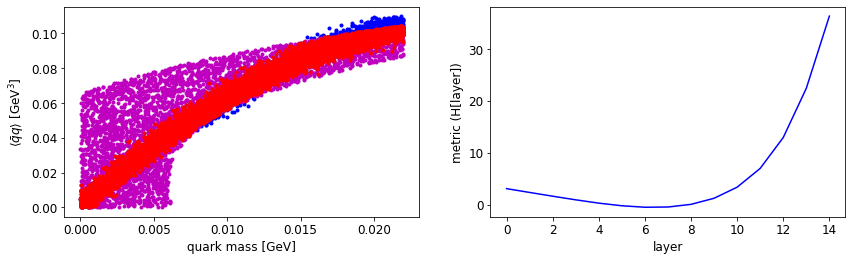

training epoch: 700,   loss: 0.07630003988742828
lambda: 0.0019379736622795463,   AdS radius: 4.699275970458984[1/GeV]


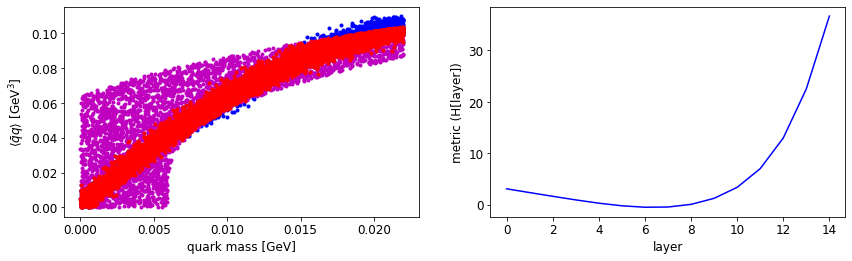

training epoch: 800,   loss: 0.07598821818828583
lambda: 0.0017981113633140922,   AdS radius: 4.752720832824707[1/GeV]


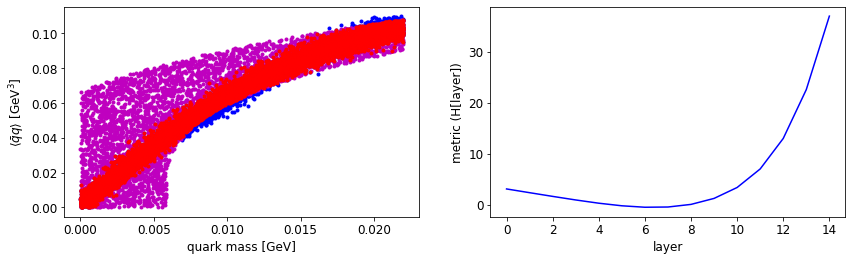

training epoch: 900,   loss: 0.07689199596643448
lambda: 0.0016363884788006544,   AdS radius: 4.740871429443359[1/GeV]


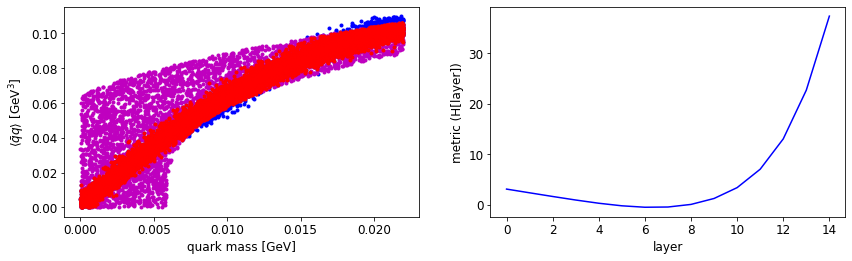

training epoch: 1000,   loss: 0.07457297295331955
lambda: 0.0016459508333355188,   AdS radius: 4.749067783355713[1/GeV]


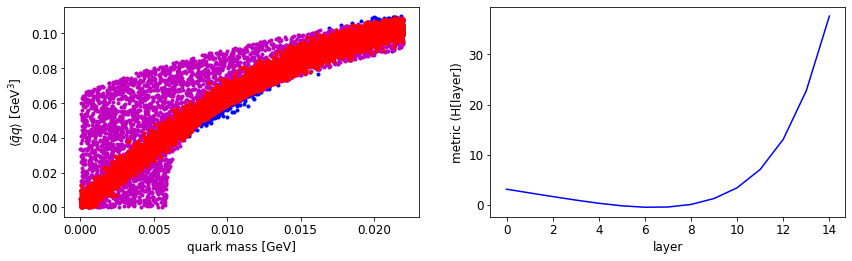

training epoch: 1100,   loss: 0.07628446817398071
lambda: 0.0013917088508605957,   AdS radius: 4.770602703094482[1/GeV]


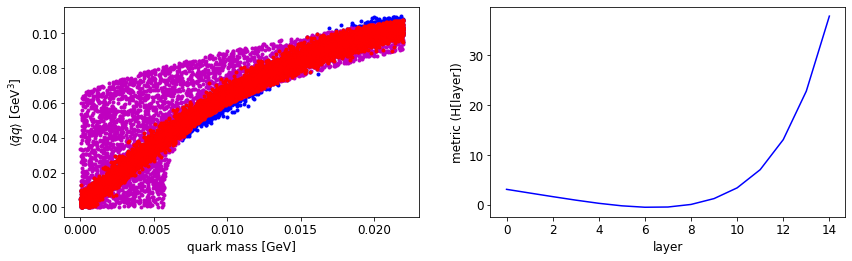

training epoch: 1200,   loss: 0.07386866211891174
lambda: 0.0014891482423990965,   AdS radius: 4.780764102935791[1/GeV]


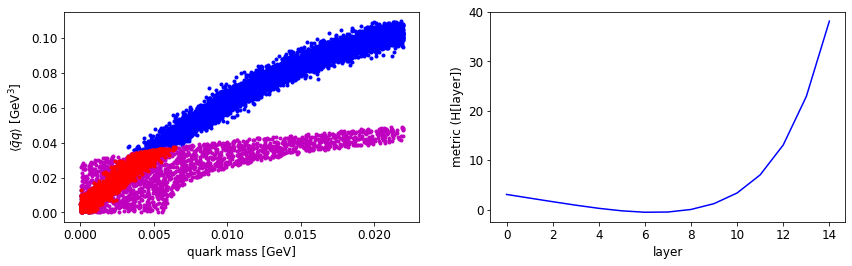

training epoch: 1300,   loss: 0.29191097617149353
lambda: 0.014605600386857986,   AdS radius: 4.749800205230713[1/GeV]


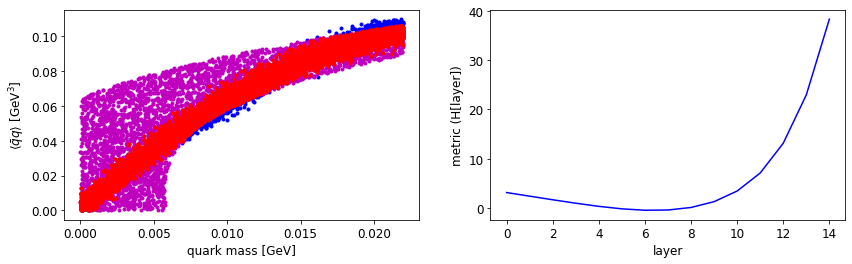

training epoch: 1400,   loss: 0.0756596177816391
lambda: 0.0018663089722394943,   AdS radius: 4.673513412475586[1/GeV]


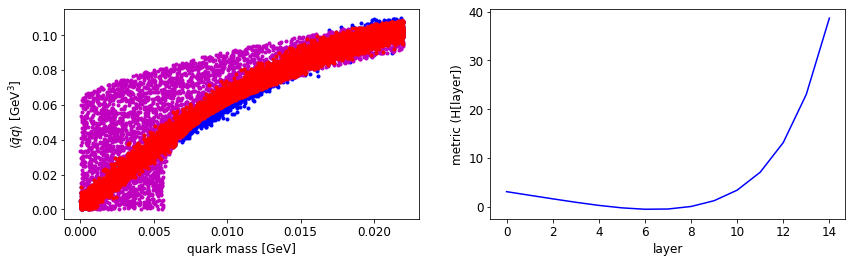

training epoch: 1500,   loss: 0.07773467898368835
lambda: 0.0015680569922551513,   AdS radius: 4.736059188842773[1/GeV]


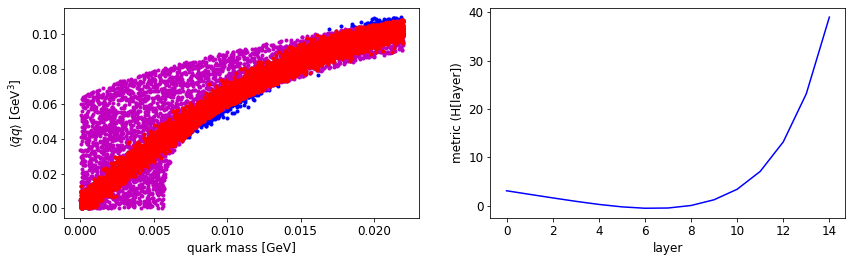

training epoch: 1600,   loss: 0.07448059320449829
lambda: 0.0015867238398641348,   AdS radius: 4.712133407592773[1/GeV]


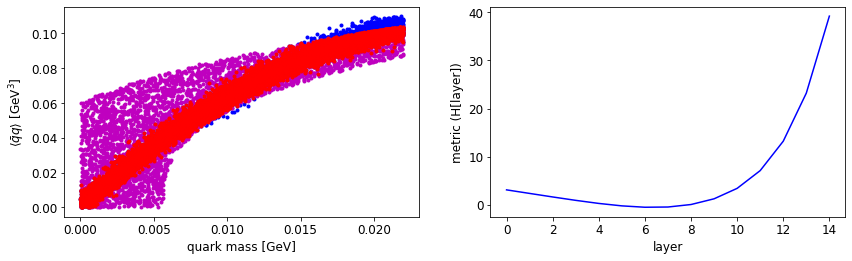

training epoch: 1700,   loss: 0.07447945326566696
lambda: 0.0016733473166823387,   AdS radius: 4.739958763122559[1/GeV]


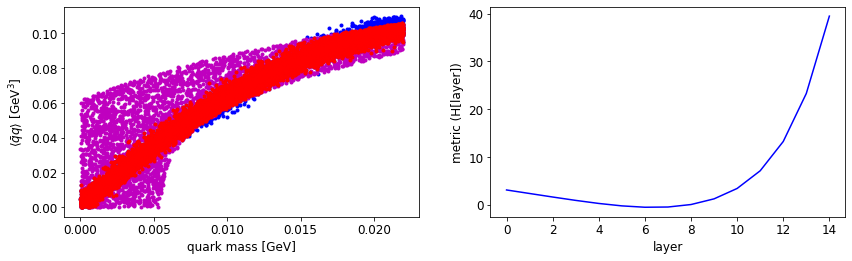

training epoch: 1800,   loss: 0.07369557023048401
lambda: 0.0014788039261475205,   AdS radius: 4.780494689941406[1/GeV]


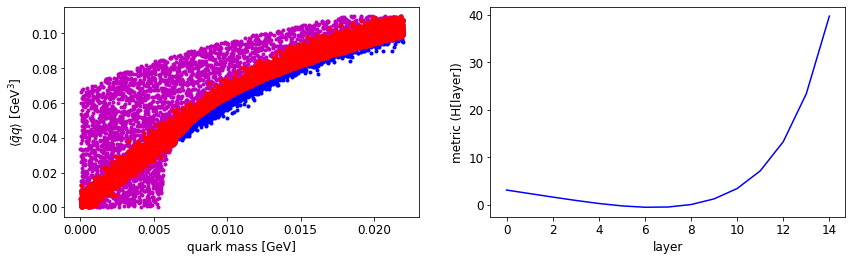

training epoch: 1900,   loss: 0.07692594826221466
lambda: 0.0012047102209180593,   AdS radius: 4.753156661987305[1/GeV]


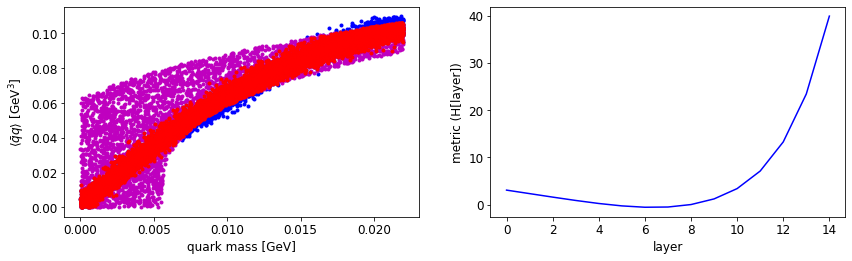

training epoch: 2000,   loss: 0.07393576204776764
lambda: 0.001822404214181006,   AdS radius: 4.668838977813721[1/GeV]


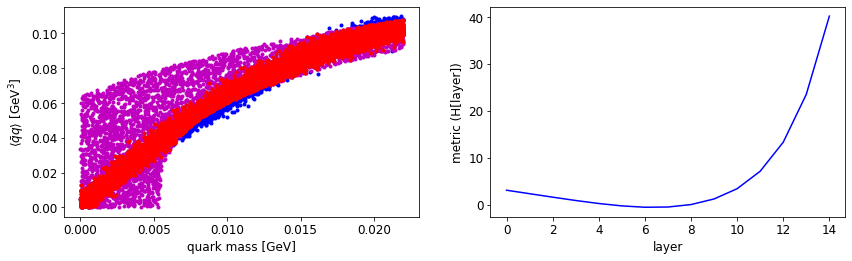

training epoch: 2100,   loss: 0.073643758893013
lambda: 0.0015056970296427608,   AdS radius: 4.757324695587158[1/GeV]


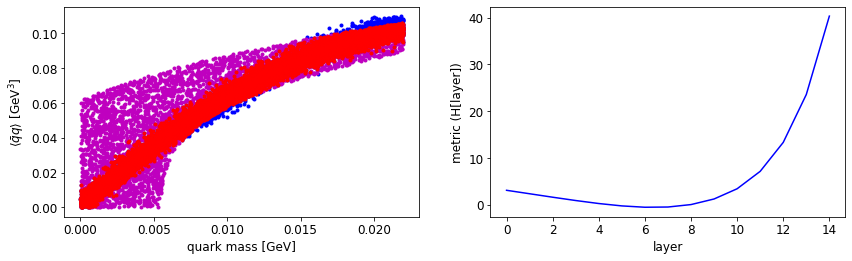

training epoch: 2200,   loss: 0.07351644337177277
lambda: 0.0017362567596137524,   AdS radius: 4.6863813400268555[1/GeV]


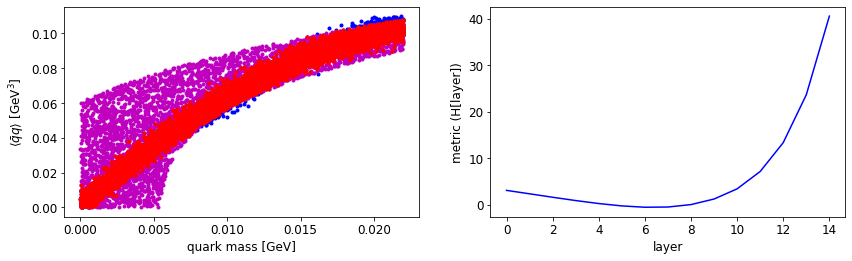

training epoch: 2300,   loss: 0.07495232671499252
lambda: 0.0015835716621950269,   AdS radius: 4.681685447692871[1/GeV]


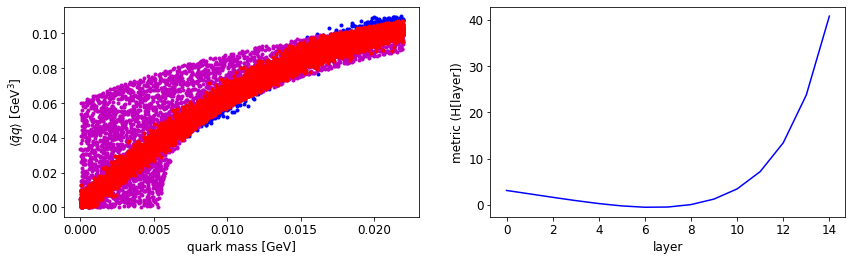

training epoch: 2400,   loss: 0.07445219904184341
lambda: 0.0016736615216359496,   AdS radius: 4.668249130249023[1/GeV]


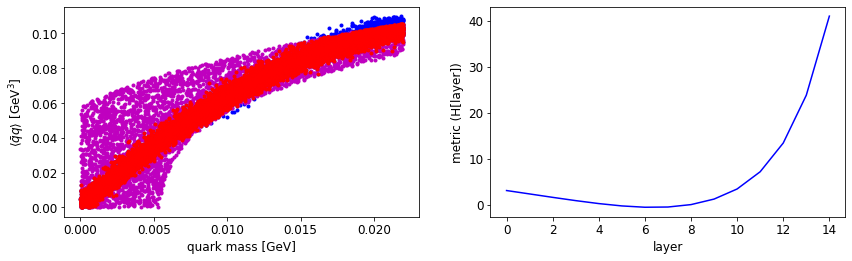

training epoch: 2500,   loss: 0.07598379999399185
lambda: 0.0016481962520629168,   AdS radius: 4.68235445022583[1/GeV]


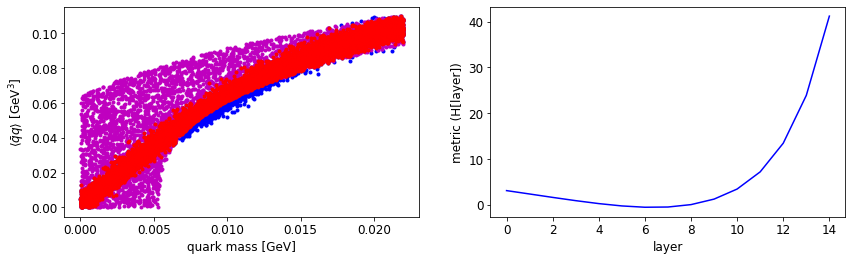

training epoch: 2600,   loss: 0.07417671382427216
lambda: 0.0015441083814948797,   AdS radius: 4.678332805633545[1/GeV]


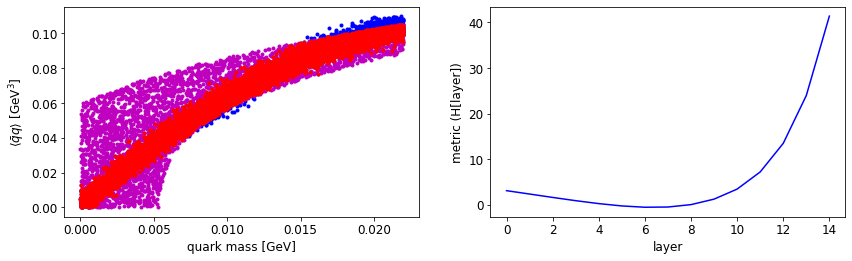

training epoch: 2700,   loss: 0.07302010804414749
lambda: 0.001880067982710898,   AdS radius: 4.635681629180908[1/GeV]


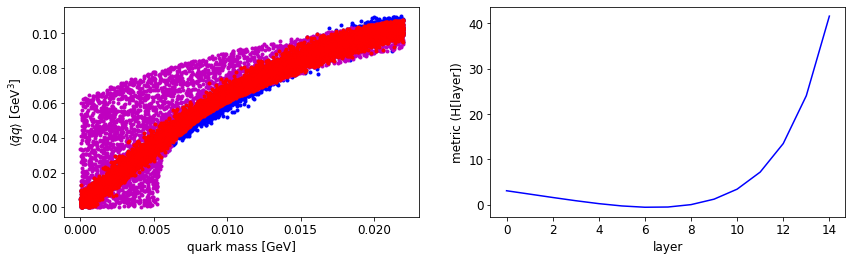

training epoch: 2800,   loss: 0.07342099398374557
lambda: 0.0015976647846400738,   AdS radius: 4.704583644866943[1/GeV]


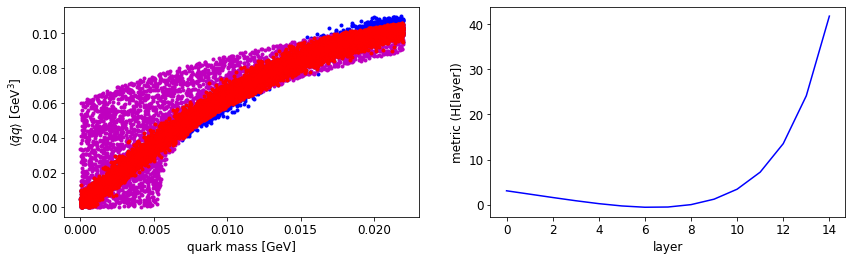

training epoch: 2900,   loss: 0.07378260791301727
lambda: 0.001948666526004672,   AdS radius: 4.607666492462158[1/GeV]


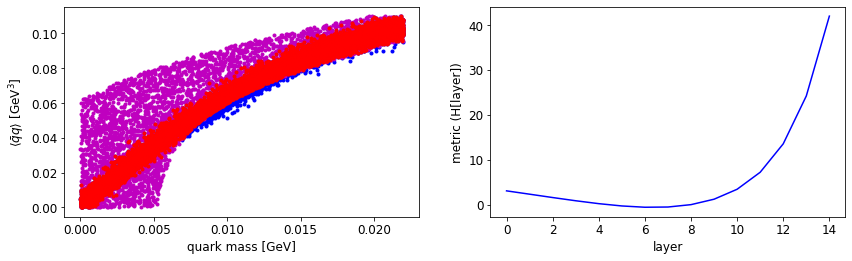

training epoch: 3000,   loss: 0.07506771385669708
lambda: 0.0013827583752572536,   AdS radius: 4.657898426055908[1/GeV]


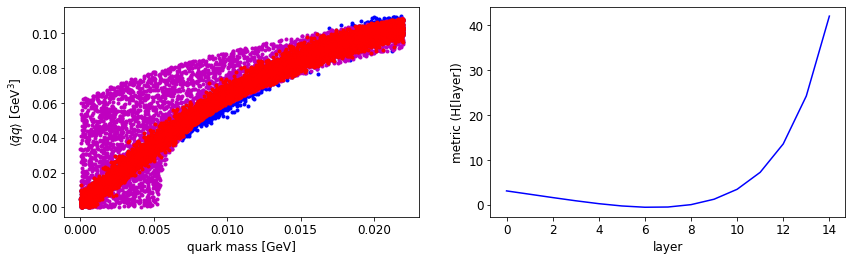

training epoch: 3100,   loss: 0.07361651957035065
lambda: 0.0019816705025732517,   AdS radius: 4.556202411651611[1/GeV]


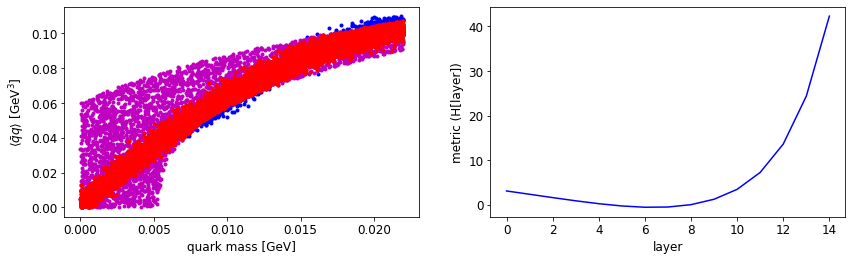

training epoch: 3200,   loss: 0.07268483936786652
lambda: 0.0019323620945215225,   AdS radius: 4.584003448486328[1/GeV]


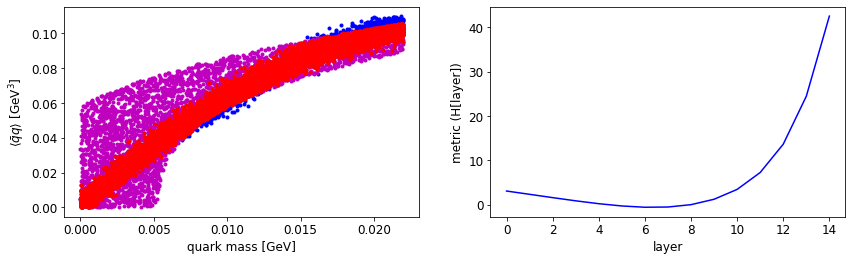

training epoch: 3300,   loss: 0.07289737462997437
lambda: 0.001948098768480122,   AdS radius: 4.59958028793335[1/GeV]


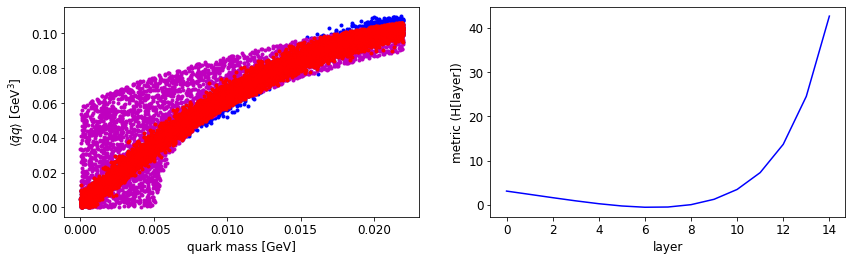

training epoch: 3400,   loss: 0.07306128740310669
lambda: 0.0017693792469799519,   AdS radius: 4.625539302825928[1/GeV]


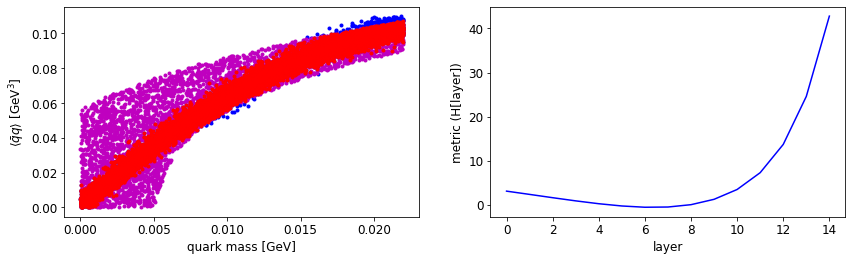

training epoch: 3500,   loss: 0.0738486498594284
lambda: 0.0016682883724570274,   AdS radius: 4.629391670227051[1/GeV]


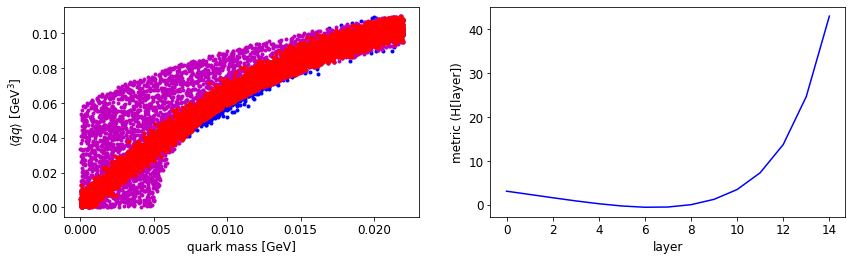

training epoch: 3600,   loss: 0.07284612208604813
lambda: 0.001377232139930129,   AdS radius: 4.6752095222473145[1/GeV]


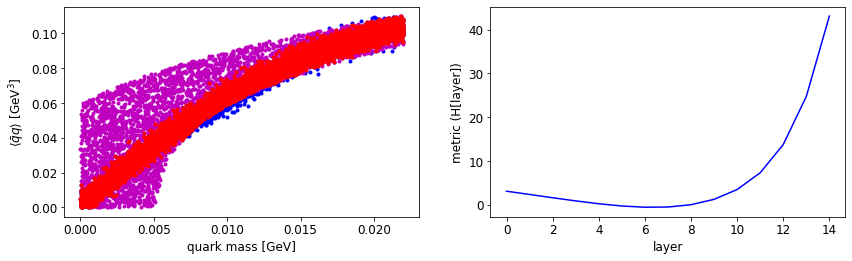

training epoch: 3700,   loss: 0.07331036031246185
lambda: 0.0015929194632917643,   AdS radius: 4.612808704376221[1/GeV]


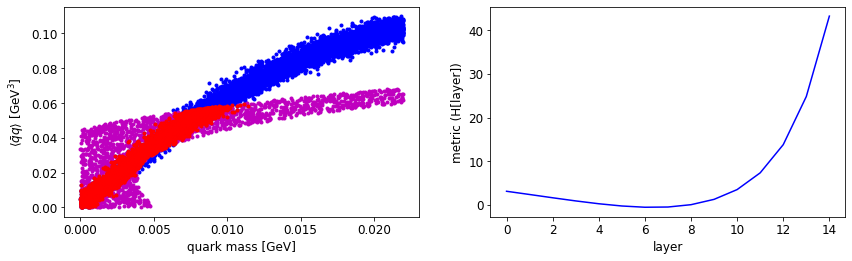

training epoch: 3800,   loss: 0.2518438696861267
lambda: 0.008422798477113247,   AdS radius: 4.648187160491943[1/GeV]


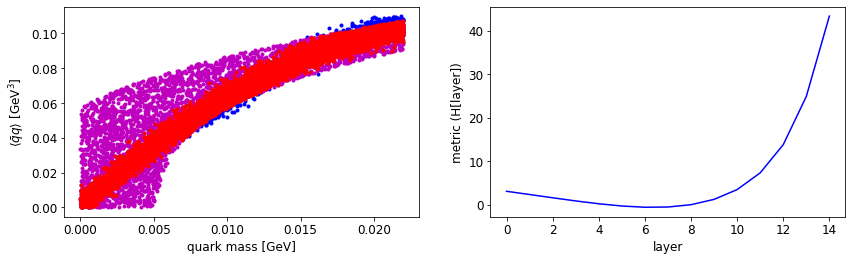

training epoch: 3900,   loss: 0.07396681606769562
lambda: 0.001845532562583685,   AdS radius: 4.579311370849609[1/GeV]


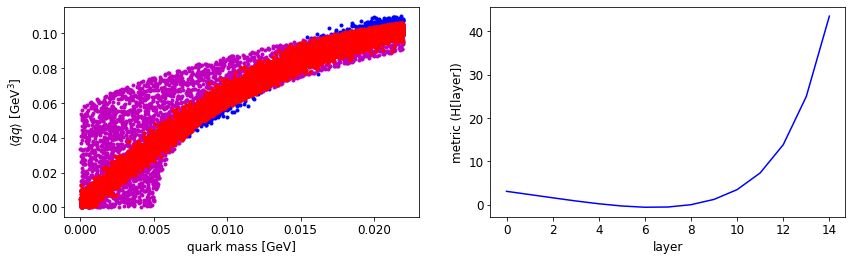

training epoch: 4000,   loss: 0.07226872444152832
lambda: 0.001967265736311674,   AdS radius: 4.562098026275635[1/GeV]


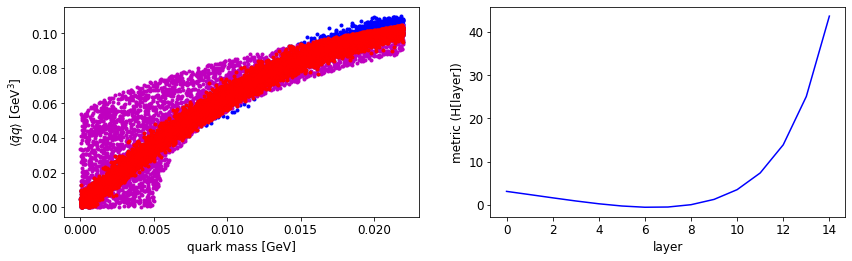

training epoch: 4100,   loss: 0.07188554853200912
lambda: 0.0018996348371729255,   AdS radius: 4.591573238372803[1/GeV]


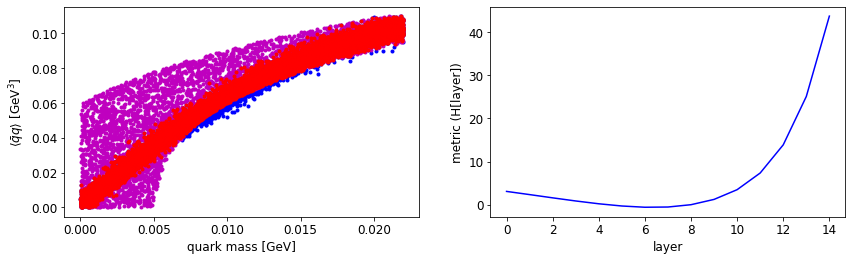

training epoch: 4200,   loss: 0.07361256331205368
lambda: 0.0015990921529009938,   AdS radius: 4.587013244628906[1/GeV]


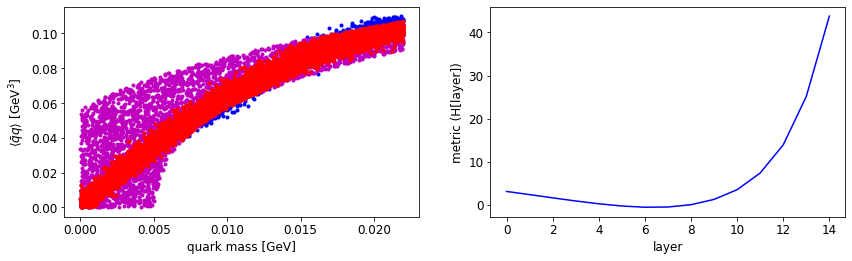

training epoch: 4300,   loss: 0.07211771607398987
lambda: 0.001961460569873452,   AdS radius: 4.54583740234375[1/GeV]


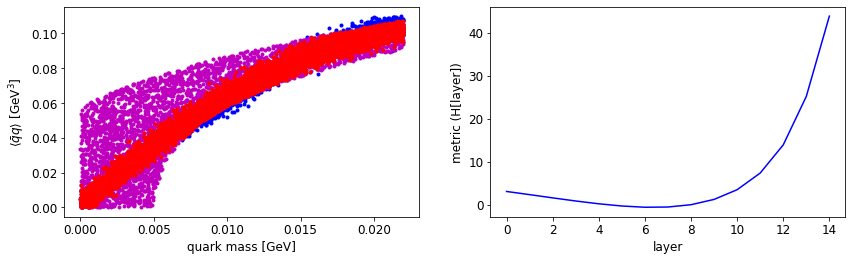

training epoch: 4400,   loss: 0.0719773918390274
lambda: 0.0019088074332103133,   AdS radius: 4.560550212860107[1/GeV]


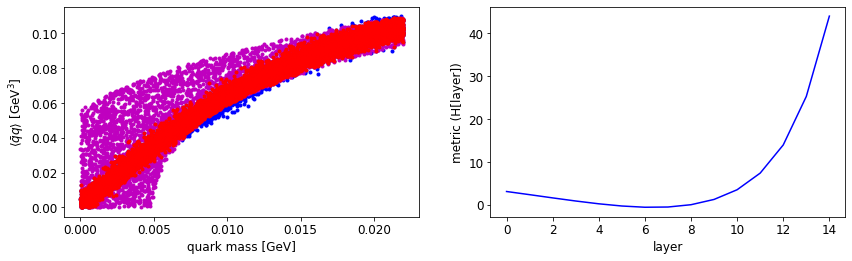

training epoch: 4500,   loss: 0.07131542265415192
lambda: 0.0014460531529039145,   AdS radius: 4.6600518226623535[1/GeV]


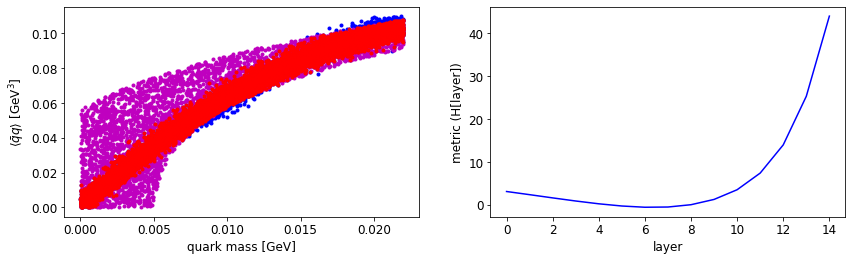

training epoch: 4600,   loss: 0.0727405697107315
lambda: 0.001926532480865717,   AdS radius: 4.534357070922852[1/GeV]


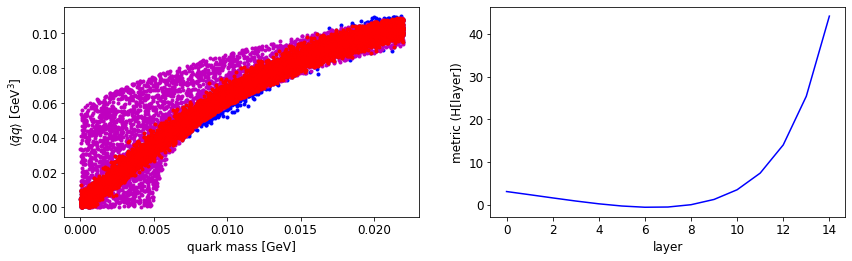

training epoch: 4700,   loss: 0.07219840586185455
lambda: 0.0017735593719407916,   AdS radius: 4.549421310424805[1/GeV]


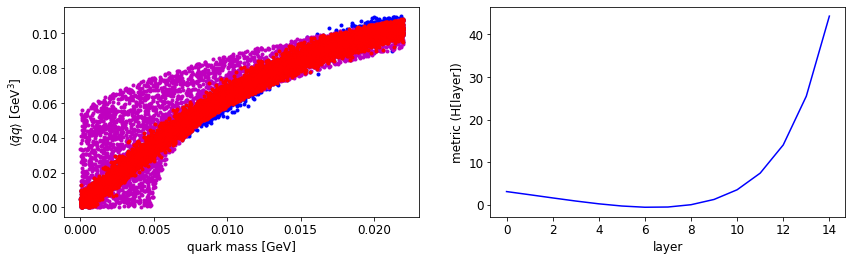

training epoch: 4800,   loss: 0.07272075116634369
lambda: 0.0018309729639440775,   AdS radius: 4.554953098297119[1/GeV]


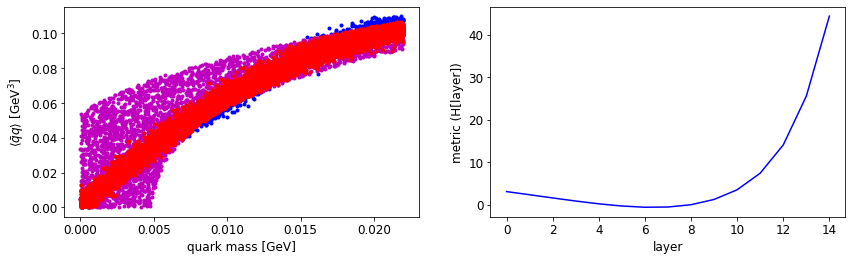

training epoch: 4900,   loss: 0.07148902118206024
lambda: 0.0017268168739974499,   AdS radius: 4.6052422523498535[1/GeV]


In [43]:
total_epoch=5000
show_epoch_each=100

for epoch in range(total_epoch):
    batches = iter(train_d_loader)
    train_loss = 0.0
    for (b_phi, b_Pi, b_ans) in batches:
        # (b_phi, b_Pi, b_ans) is a minibatch, we need to convert it to `Variable` object. 
        phi, Pi, ans = Variable(b_phi), Variable(b_Pi), Variable(b_ans)
        # calclation of loss
        loss = Test.loss(phi=phi, Pi=Pi, answer=ans, reg_coef_list=regularization_coeffs)
        # update
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
        train_loss += loss.data[0]
    if np.isnan(train_loss)==True: break

    if epoch % show_epoch_each == 0:
        negx, negy, posx, posy, Hs = plot_phase_and_metric(
                                                           threshold=.1, eta_or_layer='layer',
                                                           positive_H_M_F=positive_H_M_F,
                                                           negative_H_M_F=negative_H_M_F,
                                                           Net=Test
                                                          )
        print ("training epoch: {},   loss: {}".format(epoch, train_loss / len(train_d_loader)))
        print ("lambda: {},   AdS radius: {}[1/GeV]".format(Test.show_lamb().data.numpy()[0], Test.show_adsradius().data.numpy()[0]))
    

In [44]:
a=[Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layers)]
print(np.array(a))

[ 3.10852170e+00  2.37033582e+00  1.61626756e+00  8.87033403e-01
  2.32251495e-01 -2.83954233e-01 -5.72982073e-01 -5.19911110e-01
  2.19938494e-02  1.26096988e+00  3.53739810e+00  7.45160723e+00
  1.41011095e+01  2.56105080e+01  4.44408569e+01]


# 4. Save & load NN

Create a directry named "trained_models" by running the following cell:

In [ ]:
%%bash
mkdir trained_models

Instance "Test" of the trained MetricNet is saved there by using `torch.save`.

In [ ]:
torch.save(Test, 'trained_models/name.pt') 

To load a saved model, use `torch.load`.

In [ ]:
model = torch.load('trained_models/name.pt')

# 5. How to get trained parameters of the NN

To get the parameters as numpy array, use:

In [ ]:
model.adsradius.weight.data.numpy() # AdS radius in unit [GeV^{-1}]

In [ ]:
model.lamb.weight.data.numpy() # lambda

In [ ]:
for h in model.Hs:     # metric (h)
    np_h = h.weight.data.numpy()
    print(np_h)